In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import random as rn
from datetime import datetime
import warnings
import pickle
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# ÏãúÎìú ÏÑ§Ï†ï
RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

# XGBoost Î≤ÑÏ†Ñ ÌôïÏù∏
print(f"XGBoost Î≤ÑÏ†Ñ: {xgboost.__version__}")

print("üöÄ Ï†ÑÎ†• ÏÇ¨Ïö©Îüâ ÏòàÏ∏° ÏïôÏÉÅÎ∏î Î™®Îç∏ V3 ÏãúÏûë!")
print("=" * 50)


XGBoost Î≤ÑÏ†Ñ: 1.6.1
üöÄ Ï†ÑÎ†• ÏÇ¨Ïö©Îüâ ÏòàÏ∏° ÏïôÏÉÅÎ∏î Î™®Îç∏ V3 ÏãúÏûë!


In [2]:
# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ ÌôïÏù∏
print("üß™ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ ÌôïÏù∏...")

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
train = pd.read_csv('data/train.csv')
train = train.rename(columns={'ÏùºÏãú': 'date_time'})
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

print(f"üìÖ Ï†ÑÏ≤¥ train Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ: {train['date_time'].min()} ~ {train['date_time'].max()}")
print(f"üìä Ï†ÑÏ≤¥ train Îç∞Ïù¥ÌÑ∞ Ïàò: {len(train)}Í∞ú")
print(f"üìä Ï¥ù Í∏∞Í∞Ñ: {(train['date_time'].max() - train['date_time'].min()).days}Ïùº")
print(f"üìä Ï¥ù Ï£ºÏ∞®: {(train['date_time'].max() - train['date_time'].min()).days // 7}Ï£º")

# Í±¥Î¨º 1Í∞úÏùò Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î°ú ÌÖåÏä§Ìä∏
building_1_data = train[train['Í±¥Î¨ºÎ≤àÌò∏'] == 1].copy()
print(f"\\nüìä Í±¥Î¨º 1 Îç∞Ïù¥ÌÑ∞: {len(building_1_data)}Í∞ú")
print(f"üìÖ Í±¥Î¨º 1 Í∏∞Í∞Ñ: {building_1_data['date_time'].min()} ~ {building_1_data['date_time'].max()}")
print(f"üìä Í±¥Î¨º 1 Ï¥ù Í∏∞Í∞Ñ: {(building_1_data['date_time'].max() - building_1_data['date_time'].min()).days}Ïùº")
print(f"üìä Í±¥Î¨º 1 Ï¥ù Ï£ºÏ∞®: {(building_1_data['date_time'].max() - building_1_data['date_time'].min()).days // 7}Ï£º")


üß™ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ ÌôïÏù∏...
üìÖ Ï†ÑÏ≤¥ train Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ: 2024-06-01 00:00:00 ~ 2024-08-24 23:00:00
üìä Ï†ÑÏ≤¥ train Îç∞Ïù¥ÌÑ∞ Ïàò: 204000Í∞ú
üìä Ï¥ù Í∏∞Í∞Ñ: 84Ïùº
üìä Ï¥ù Ï£ºÏ∞®: 12Ï£º
\nüìä Í±¥Î¨º 1 Îç∞Ïù¥ÌÑ∞: 2040Í∞ú
üìÖ Í±¥Î¨º 1 Í∏∞Í∞Ñ: 2024-06-01 00:00:00 ~ 2024-08-24 23:00:00
üìä Í±¥Î¨º 1 Ï¥ù Í∏∞Í∞Ñ: 84Ïùº
üìä Í±¥Î¨º 1 Ï¥ù Ï£ºÏ∞®: 12Ï£º


In [3]:
def smape(gt, preds):
    """SMAPE (Symmetric Mean Absolute Percentage Error) Í≥ÑÏÇ∞"""
    gt = np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score
    
def weighted_mse(alpha=1):
    """Í∞ÄÏ§ë MSE ÏÜêÏã§ Ìï®Ïàò (Under-predictionÏóê Îçî ÌÅ∞ ÌéòÎÑêÌã∞)"""
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual > 0, -2 * alpha * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

def custom_smape(preds, dtrain):
    """XGBoostÏö© SMAPE ÌèâÍ∞Ä Ìï®Ïàò"""
    labels = dtrain.get_label()
    return 'custom_smape', np.mean(2 * abs(preds - labels) / (abs(preds) + abs(labels))) * 100

print("‚úÖ ÌèâÍ∞Ä Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å")


‚úÖ ÌèâÍ∞Ä Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å


In [4]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
print("üìä Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë...")
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
building_info = pd.read_csv('data/building_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print(f"‚úÖ Train Îç∞Ïù¥ÌÑ∞: {train.shape}")
print(f"‚úÖ Test Îç∞Ïù¥ÌÑ∞: {test.shape}")
print(f"‚úÖ Building info: {building_info.shape}")

# Ïª¨ÎüºÎ™Ö ÏòÅÏñ¥Î°ú Î≥ÄÍ≤Ω (ÏûëÎÖÑ ÏàòÏÉÅÏûê Î∞©Ïãù)
train = train.rename(columns={
    'Í±¥Î¨ºÎ≤àÌò∏': 'building_number',
    'ÏùºÏãú': 'date_time',
    'Í∏∞Ïò®(¬∞C)': 'temperature',
    'Í∞ïÏàòÎüâ(mm)': 'rainfall',
    'ÌíçÏÜç(m/s)': 'windspeed',
    'ÏäµÎèÑ(%)': 'humidity',
    'ÏùºÏ°∞(hr)': 'sunshine',
    'ÏùºÏÇ¨(MJ/m2)': 'solar_radiation',
    'Ï†ÑÎ†•ÏÜåÎπÑÎüâ(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis=1, inplace=True)

test = test.rename(columns={
    'Í±¥Î¨ºÎ≤àÌò∏': 'building_number',
    'ÏùºÏãú': 'date_time',
    'Í∏∞Ïò®(¬∞C)': 'temperature',
    'Í∞ïÏàòÎüâ(mm)': 'rainfall',
    'ÌíçÏÜç(m/s)': 'windspeed',
    'ÏäµÎèÑ(%)': 'humidity',
    'ÏùºÏ°∞(hr)': 'sunshine',
    'ÏùºÏÇ¨(MJ/m2)': 'solar_radiation'
})
test.drop('num_date_time', axis=1, inplace=True)

building_info = building_info.rename(columns={
    'Í±¥Î¨ºÎ≤àÌò∏': 'building_number',
    'Í±¥Î¨ºÏú†Ìòï': 'building_type',
    'Ïó∞Î©¥Ï†Å(m2)': 'total_area',
    'ÎÉâÎ∞©Î©¥Ï†Å(m2)': 'cooling_area',
    'ÌÉúÏñëÍ¥ëÏö©Îüâ(kW)': 'solar_power_capacity',
    'ESSÏ†ÄÏû•Ïö©Îüâ(kWh)': 'ess_capacity',
    'PCSÏö©Îüâ(kW)': 'pcs_capacity'
})

# Í±¥Î¨º Ïú†Ìòï ÏòÅÏñ¥Î°ú Î≤àÏó≠
translation_dict = {
    'Í±¥Î¨ºÍ∏∞ÌÉÄ': 'Other Buildings',
    'Í≥µÍ≥µ': 'Public',
    'ÌïôÍµê': 'University',
    'Î∞±ÌôîÏ†ê': 'Department Store',
    'Î≥ëÏõê': 'Hospital',
    'ÏÉÅÏö©': 'Commercial',
    'ÏïÑÌååÌä∏': 'Apartment',
    'Ïó∞Íµ¨ÏÜå': 'Research Institute',
    'IDC(Ï†ÑÌôîÍµ≠)': 'IDC',
    'Ìò∏ÌÖî': 'Hotel'
}
building_info['building_type'] = building_info['building_type'].replace(translation_dict)

# ÌÉúÏñëÍ¥ë/ESS ÏÑ§ÎπÑ Ïú†Î¨¥ ÌîºÏ≤ò ÏÉùÏÑ±
building_info['solar_power_utility'] = np.where(building_info.solar_power_capacity != '-', 1, 0)
building_info['ess_utility'] = np.where(building_info.ess_capacity != '-', 1, 0)

# Í±¥Î¨º Ï†ïÎ≥¥ Î≥ëÌï©
train = pd.merge(train, building_info, on='building_number', how='left')
test = pd.merge(test, building_info, on='building_number', how='left')

print("‚úÖ Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å")


üìä Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë...
‚úÖ Train Îç∞Ïù¥ÌÑ∞: (204000, 10)
‚úÖ Test Îç∞Ïù¥ÌÑ∞: (16800, 7)
‚úÖ Building info: (100, 7)
‚úÖ Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å


In [5]:
# ÎÇ†Ïßú/ÏãúÍ∞Ñ Î≥ÄÌôò Î∞è Í∏∞Î≥∏ ÏãúÍ∞Ñ ÌîºÏ≤ò ÏÉùÏÑ±
print("üîß Feature Engineering ÏãúÏûë...")

train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# Í∏∞Î≥∏ ÏãúÍ∞Ñ ÌîºÏ≤ò
for df in [train, test]:
    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df['day_of_week'] = df['date_time'].dt.dayofweek

print("‚úÖ Í∏∞Î≥∏ ÏãúÍ∞Ñ ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å")


üîß Feature Engineering ÏãúÏûë...
‚úÖ Í∏∞Î≥∏ ÏãúÍ∞Ñ ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å


In [6]:
# ÏùºÎ≥Ñ Ïò®ÎèÑ ÌÜµÍ≥Ñ ÌîºÏ≤ò ÏÉùÏÑ±
def calculate_day_values(dataframe, target_column, output_column, aggregation_func):
    """ÏùºÎ≥Ñ ÌÜµÍ≥ÑÍ∞í Í≥ÑÏÇ∞ Ìï®Ïàò"""
    result_dict = {}
    grouped_temp = dataframe.groupby(['building_number', 'month', 'day'])[target_column].agg(aggregation_func)
    
    for (building, month, day), value in grouped_temp.items():
        result_dict.setdefault(building, {}).setdefault(month, {})[day] = value
    
    dataframe[output_column] = [
        result_dict.get(row['building_number'], {}).get(row['month'], {}).get(row['day'], None)
        for _, row in dataframe.iterrows()
    ]

# ÏùºÎ≥Ñ Ïò®ÎèÑ ÌÜµÍ≥Ñ ÌîºÏ≤ò ÏÉùÏÑ±
for df in [train, test]:
    calculate_day_values(df, 'temperature', 'day_max_temperature', 'max')
    calculate_day_values(df, 'temperature', 'day_mean_temperature', 'mean')
    calculate_day_values(df, 'temperature', 'day_min_temperature', 'min')
    df['day_temperature_range'] = df['day_max_temperature'] - df['day_min_temperature']

print("‚úÖ ÏùºÎ≥Ñ Ïò®ÎèÑ ÌÜµÍ≥Ñ ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å")


‚úÖ ÏùºÎ≥Ñ Ïò®ÎèÑ ÌÜµÍ≥Ñ ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å


In [7]:
# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Î∞è Ï∂îÍ∞Ä ÌîºÏ≤ò ÏÉùÏÑ± (0 Ï†úÍ±∞)
outlier_idx = train.index[train['power_consumption'] == 0].tolist()
print(f"Ï†úÍ±∞Ìï† Ïù¥ÏÉÅÏπò Í∞úÏàò: {len(outlier_idx)}")
train.drop(index=outlier_idx, inplace=True)
print(f"ÎÇ®ÏùÄ Ìñâ Í∞úÏàò: {train.shape[0]}")

Ï†úÍ±∞Ìï† Ïù¥ÏÉÅÏπò Í∞úÏàò: 68
ÎÇ®ÏùÄ Ìñâ Í∞úÏàò: 203932


In [8]:
# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ (Z-score Í∏∞Î∞ò )
import numpy as np
from scipy import stats

def detect_outliers_zscore_only(train, threshold=4.5):
    """
    Z-score Î∞©Î≤ïÏúºÎ°úÎßå Ïù¥ÏÉÅÏπòÎ•º Ï∞æÏïÑÎÇ¥Îäî Ìï®Ïàò
    
    Args:
        train (pd.DataFrame): Ï†ÑÏ≤òÎ¶¨Îêú Ï†ÑÏ≤¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞
        threshold (float): Z-score ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏Í∞í: 3)
    
    Returns:
        pd.DataFrame: Ïù¥ÏÉÅÏπò Îç∞Ïù¥ÌÑ∞
    """
    print(f"ÔøΩÔøΩ Z-score Î∞©Î≤ïÏúºÎ°ú Ïù¥ÏÉÅÏπò ÌÉêÏßÄ (ÏûÑÍ≥ÑÍ∞í: {threshold})")
    print("=" * 60)
    
    outliers_list = []
    
    for building_num in train['building_number'].unique():
        building_data = train[train['building_number'] == building_num]['power_consumption']
        
        # Z-score Í≥ÑÏÇ∞
        z_scores = np.abs(stats.zscore(building_data))
        
        # ÏûÑÍ≥ÑÍ∞íÏùÑ Ï¥àÍ≥ºÌïòÎäî Ïù¥ÏÉÅÏπò Ï∞æÍ∏∞
        building_outliers = train[(train['building_number'] == building_num) & 
                                          (z_scores > threshold)]
        
        if not building_outliers.empty:
            outliers_list.append(building_outliers)
    
    outliers_df = pd.concat(outliers_list) if outliers_list else pd.DataFrame()
    
    print(f"üìä Î∞úÍ≤¨Îêú Ïù¥ÏÉÅÏπò: {len(outliers_df)}Í∞ú")
    
    if not outliers_df.empty:
        print(f"ÔøΩÔøΩ Ïù¥ÏÉÅÏπòÍ∞Ä ÏûàÎäî Í±¥Î¨º Ïàò: {outliers_df['building_number'].nunique()}Í∞ú")
        print(f"üè¢ Ïù¥ÏÉÅÏπòÍ∞Ä ÏûàÎäî Í±¥Î¨º Î≤àÌò∏: {sorted(outliers_df['building_number'].unique())}")
        
        # Í±¥Î¨ºÎ≥Ñ Ïù¥ÏÉÅÏπò Í∞úÏàò
        building_counts = outliers_df['building_number'].value_counts()
        print(f"\nüìà Í±¥Î¨ºÎ≥Ñ Ïù¥ÏÉÅÏπò Í∞úÏàò:")
        for building_num, count in building_counts.items():
            building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
            print(f"   Í±¥Î¨º {building_num} ({building_type}): {count}Í∞ú")
    else:
        print("‚úÖ Ïù¥ÏÉÅÏπòÍ∞Ä Î∞úÍ≤¨ÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")
    
    return outliers_df

# Z-score Ïù¥ÏÉÅÏπò ÌÉêÏßÄ Ïã§Ìñâ
outliers_df = detect_outliers_zscore_only(train, threshold=4.5)

# Ïù¥ÏÉÅÏπò ÏÉÅÏÑ∏ Î∂ÑÏÑù
if not outliers_df.empty:
    print(f"\nüìä Ïù¥ÏÉÅÏπò ÏÉÅÏÑ∏ Î∂ÑÏÑù:")
    print("=" * 60)
    
    for building_num in sorted(outliers_df['building_number'].unique()):
        building_outliers = outliers_df[outliers_df['building_number'] == building_num]
        building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
        
        print(f"\nüè¢ Í±¥Î¨º {building_num} ({building_type}):")
        print(f"   Ïù¥ÏÉÅÏπò Í∞úÏàò: {len(building_outliers)}Í∞ú")
        print(f"   ÏµúÏÜå Ï†ÑÎ†•ÏÜåÎπÑÎüâ: {building_outliers['power_consumption'].min():.2f} kWh")
        print(f"   ÏµúÎåÄ Ï†ÑÎ†•ÏÜåÎπÑÎüâ: {building_outliers['power_consumption'].max():.2f} kWh")
        print(f"   ÌèâÍ∑† Ï†ÑÎ†•ÏÜåÎπÑÎüâ: {building_outliers['power_consumption'].mean():.2f} kWh")
        
        # Ï†ÑÏ≤¥ Í±¥Î¨º Îç∞Ïù¥ÌÑ∞ÏôÄ ÎπÑÍµê
        building_all = train[train['building_number'] == building_num]
        print(f"   Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÌèâÍ∑†: {building_all['power_consumption'].mean():.2f} kWh")
        print(f"   Ïù¥ÏÉÅÏπò ÎπÑÏú®: {len(building_outliers)/len(building_all)*100:.2f}%")

ÔøΩÔøΩ Z-score Î∞©Î≤ïÏúºÎ°ú Ïù¥ÏÉÅÏπò ÌÉêÏßÄ (ÏûÑÍ≥ÑÍ∞í: 4.5)
üìä Î∞úÍ≤¨Îêú Ïù¥ÏÉÅÏπò: 68Í∞ú
ÔøΩÔøΩ Ïù¥ÏÉÅÏπòÍ∞Ä ÏûàÎäî Í±¥Î¨º Ïàò: 11Í∞ú
üè¢ Ïù¥ÏÉÅÏπòÍ∞Ä ÏûàÎäî Í±¥Î¨º Î≤àÌò∏: [23, 30, 41, 43, 52, 64, 67, 72, 76, 81, 99]

üìà Í±¥Î¨ºÎ≥Ñ Ïù¥ÏÉÅÏπò Í∞úÏàò:
   Í±¥Î¨º 67 (IDC): 48Í∞ú
   Í±¥Î¨º 41 (Commercial): 4Í∞ú
   Í±¥Î¨º 43 (IDC): 4Í∞ú
   Í±¥Î¨º 30 (IDC): 2Í∞ú
   Í±¥Î¨º 52 (IDC): 2Í∞ú
   Í±¥Î¨º 76 (Commercial): 2Í∞ú
   Í±¥Î¨º 99 (Commercial): 2Í∞ú
   Í±¥Î¨º 23 (Research Institute): 1Í∞ú
   Í±¥Î¨º 64 (IDC): 1Í∞ú
   Í±¥Î¨º 72 (Public): 1Í∞ú
   Í±¥Î¨º 81 (IDC): 1Í∞ú

üìä Ïù¥ÏÉÅÏπò ÏÉÅÏÑ∏ Î∂ÑÏÑù:

üè¢ Í±¥Î¨º 23 (Research Institute):
   Ïù¥ÏÉÅÏπò Í∞úÏàò: 1Í∞ú
   ÏµúÏÜå Ï†ÑÎ†•ÏÜåÎπÑÎüâ: 9324.00 kWh
   ÏµúÎåÄ Ï†ÑÎ†•ÏÜåÎπÑÎüâ: 9324.00 kWh
   ÌèâÍ∑† Ï†ÑÎ†•ÏÜåÎπÑÎüâ: 9324.00 kWh
   Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÌèâÍ∑†: 2339.77 kWh
   Ïù¥ÏÉÅÏπò ÎπÑÏú®: 0.05%

üè¢ Í±¥Î¨º 30 (IDC):
   Ïù¥ÏÉÅÏπò Í∞úÏàò: 2Í∞ú
   ÏµúÏÜå Ï†ÑÎ†•ÏÜåÎπÑÎüâ: 2444.40 kWh
   ÏµúÎåÄ Ï†ÑÎ†•ÏÜåÎπÑÎüâ: 7374.24 kWh
   ÌèâÍ∑† Ï†ÑÎ†•ÏÜåÎπ

In [9]:
def drop_outliers_safe(train, outliers_df):
    """
    ÏïàÏ†ÑÌïú Î∞©Î≤ïÏúºÎ°ú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ (Î™®Îì† Ïª¨Îüº Îß§Ïπ≠)
    
    Args:
        train (pd.DataFrame): Ï†ÑÏ≤¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞
        outliers_df (pd.DataFrame): Ïù¥ÏÉÅÏπò Îç∞Ïù¥ÌÑ∞
    
    Returns:
        pd.DataFrame: Ïù¥ÏÉÅÏπòÍ∞Ä Ï†úÍ±∞Îêú Îç∞Ïù¥ÌÑ∞
    """
    print(f"üîç ÏïàÏ†ÑÌïú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÏãúÏûë")
    print(f"   ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {len(train)}Í∞ú")
    print(f"   Ï†úÍ±∞Ìï† Ïù¥ÏÉÅÏπò Í∞úÏàò: {len(outliers_df)}Í∞ú")
    
    # Ï†ïÏ†úÎêú Îç∞Ïù¥ÌÑ∞ Ï¥àÍ∏∞Ìôî
    cleaned_data = train.copy()
    
    # Ïù¥ÏÉÅÏπòÍ∞Ä ÏûàÎäî Í±¥Î¨ºÎì§Îßå Ï≤òÎ¶¨
    outlier_buildings = outliers_df['building_number'].unique()
    
    removed_count = 0
    for building_num in outlier_buildings:
        building_outliers = outliers_df[outliers_df['building_number'] == building_num]
        
        # Ìï¥Îãπ Í±¥Î¨ºÏùò Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ïù¥ÏÉÅÏπò Ï†úÍ±∞
        building_mask = cleaned_data['building_number'] == building_num
        
        for _, outlier_row in building_outliers.iterrows():
            # Ï†ïÌôïÌûà ÏùºÏπòÌïòÎäî Ìñâ Ï∞æÍ∏∞
            match_mask = (
                (cleaned_data['building_number'] == outlier_row['building_number']) &
                (cleaned_data['date_time'] == outlier_row['date_time']) &
                (cleaned_data['power_consumption'] == outlier_row['power_consumption'])
            )
            
            # ÏùºÏπòÌïòÎäî Ìñâ Ï†úÍ±∞
            cleaned_data = cleaned_data[~match_mask]
            removed_count += match_mask.sum()
    
    print(f"   Ï†úÍ±∞ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {len(cleaned_data)}Í∞ú")
    print(f"   Ïã§Ï†ú Ï†úÍ±∞Îêú Ìñâ Ïàò: {removed_count}Í∞ú")
    print(f"   Ï†úÍ±∞Îêú Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®: {removed_count/len(train)*100:.2f}%")
    
    return cleaned_data

# ÏïàÏ†ÑÌïú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ïã§Ìñâ
train = drop_outliers_safe(train, outliers_df)

# Í≤∞Í≥º ÌôïÏù∏
print(f"\nüìä ÏïàÏ†ÑÌïú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Í≤∞Í≥º:")
print(f"   ÌôïÏù∏: {len(train)}Í∞ú")

# Ï†ïÏ†úÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÉàÎ°úÏö¥ Î≥ÄÏàòÏóê Ï†ÄÏû•
print(f"\n‚úÖ train Î≥ÄÏàòÏóê Ï†ïÏ†úÎêú Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

üîç ÏïàÏ†ÑÌïú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÏãúÏûë
   ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: 203932Í∞ú
   Ï†úÍ±∞Ìï† Ïù¥ÏÉÅÏπò Í∞úÏàò: 68Í∞ú
   Ï†úÍ±∞ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: 203864Í∞ú
   Ïã§Ï†ú Ï†úÍ±∞Îêú Ìñâ Ïàò: 68Í∞ú
   Ï†úÍ±∞Îêú Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®: 0.03%

üìä ÏïàÏ†ÑÌïú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Í≤∞Í≥º:
   ÌôïÏù∏: 203864Í∞ú

‚úÖ train Î≥ÄÏàòÏóê Ï†ïÏ†úÎêú Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


In [10]:
# Í≥µÌú¥Ïùº(holiday), Ï£ºÎßê(weekend), Îã´ÏùÄÎÇ†(close)Î°ú ÏÑ∏Î∂ÑÌôî# 

In [11]:
# 1. Í∏∞Î≥∏ Í≥µÌú¥Ïùº Î∞è Ï£ºÎßê ÌîºÏ≤ò ÏÉùÏÑ±
holi_weekday = ['2024-06-06', '2024-08-15']  # Í≥µÌú¥Ïùº Î™©Î°ù
for df in [train, test]:
    # Í≥µÌú¥Ïùº (Íµ≠Í∞Ä Í≥µÌú¥Ïùº)
    df['holiday'] = np.where(
        df.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday), 1, 0
    )
    
    # Ï£ºÎßê (ÌÜ†ÏöîÏùº, ÏùºÏöîÏùº)
    df['weekend'] = np.where(
        df.day_of_week >= 5, 1, 0
    )
    
    # Îã´ÏùÄÎÇ† (Ï¥àÍ∏∞Í∞í 0ÏúºÎ°ú ÏÑ§Ï†ï, ÎÇòÏ§ëÏóê Í±¥Î¨ºÎ≥Ñ Í∑úÏπô Ï†ÅÏö©)
    df['close'] = 0


# Ï£ºÍ∏∞ÏÑ± ÌîºÏ≤ò ÏÉùÏÑ± (Cyclical Features)
for df in [train, test]:
    # ÏãúÍ∞Ñ Ï£ºÍ∏∞ÏÑ±
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 23.0)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 23.0)
    
    # ÎÇ†Ïßú Ï£ºÍ∏∞ÏÑ±
    df['sin_date'] = -np.sin(2 * np.pi * (df['month'] + df['day'] / 31) / 12)
    df['cos_date'] = -np.cos(2 * np.pi * (df['month'] + df['day'] / 31) / 12)
    
    # Ïõî Ï£ºÍ∏∞ÏÑ±
    df['sin_month'] = -np.sin(2 * np.pi * df['month'] / 12.0)
    df['cos_month'] = -np.cos(2 * np.pi * df['month'] / 12.0)
    
    # ÏöîÏùº Ï£ºÍ∏∞ÏÑ±
    df['sin_dayofweek'] = -np.sin(2 * np.pi * (df['day_of_week'] + 1) / 7.0)
    df['cos_dayofweek'] = -np.cos(2 * np.pi * (df['day_of_week'] + 1) / 7.0)



In [12]:
def apply_specific_building_holidays(df):
    """
    ÌäπÏ†ï Í±¥Î¨ºÎì§Ïùò Ìú¥Ïùº Í∑úÏπôÏùÑ Ï†ÅÏö©ÌïòÎäî Ìï®Ïàò
    - 18Î≤à Í±¥Î¨º: Îß§Ï£º ÏùºÏöîÏùº Ìú¥Î¨¥ (close)
    - 27, 40, 59, 63Î≤à Í±¥Î¨º: ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Î¨¥ (close)
    - 29Î≤à Í±¥Î¨º: Îß§Îã¨ 10Ïùº + 5Î≤àÏß∏ Ï£º ÏùºÏöîÏùº Ìú¥Î¨¥ (close)
    - 32Î≤à Í±¥Î¨º: ÌôÄÏàò Ï£º ÏõîÏöîÏùº Ìú¥Î¨¥ (close)
    """
    print("üîß ÌäπÏ†ï Í±¥Î¨º Ìú¥Ïùº Í∑úÏπô Ï†ÅÏö© Ï§ë... (Îã¨Î†• Í∏∞Ï§Ä Ï£ºÏ∞®)")
    department_store_buildings = building_info[building_info['building_type'] == 'Department Store']['building_number'].tolist()

    # Îß§Ï£º ÏùºÏöîÏùº Ìú¥Î¨¥ Í±¥Î¨º (18Î≤à)
    every_sunday_buildings = [18]

    # ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Î¨¥ Í±¥Î¨ºÎì§ (27, 40, 59, 63)
    odd_week_sunday_buildings = [27, 40, 59, 63]

    # Îß§Îã¨ 10Ïùº + 5Î≤àÏß∏ Ï£º ÏùºÏöîÏùº Ìú¥Î¨¥ Í±¥Î¨º (29)
    special_holiday_building = [29]

    # ÌôÄÏàò Ï£º ÏõîÏöîÏùº Ìú¥Î¨¥ Í±¥Î¨º (32)
    odd_week_monday_buildings = [32]

    # Îã¨Î†• Í∏∞Ï§Ä Ï£ºÏ∞® Í≥ÑÏÇ∞ (ÏùºÏöîÏùº ÏãúÏûë)
    def get_calendar_week_of_month(date_series):
        """Îã¨Î†• Í∏∞Ï§Ä Ï£ºÏ∞® Í≥ÑÏÇ∞ (ÏõîÏùò Ï≤´ÎÇ†Ïù¥ Ìè¨Ìï®Îêú Ï£ºÎ•º 1Ï£ºÏ∞®Î°ú)"""
        result = []
        for date in date_series:
            first_day = date.replace(day=1)
            first_day_weekday = first_day.weekday()
            days_to_week_start = (first_day_weekday + 1) % 7  # ÏùºÏöîÏùº Í∏∞Ï§Ä
            week_start_of_first = first_day - pd.Timedelta(days=days_to_week_start)
            days_since_first_week_start = (date - week_start_of_first).days
            week_num = (days_since_first_week_start // 7) + 1
            result.append(week_num)
        return result

    # Îã¨Î†• Í∏∞Ï§Ä Ï£ºÏ∞® Í≥ÑÏÇ∞
    df['calendar_week_of_month'] = get_calendar_week_of_month(df['date_time'])

    # 0. Îß§Ï£º ÏùºÏöîÏùº Ìú¥Î¨¥ (18Î≤à Í±¥Î¨º) - closeÏóê Ï†ÅÏö©
    for building_num in every_sunday_buildings:
        mask = (df['building_number'] == building_num) & (df['day_of_week'] == 6)
        df.loc[mask, 'close'] = 1
        count = mask.sum()
        print(f"   Í±¥Î¨º {building_num}: Îß§Ï£º ÏùºÏöîÏùº Ìú¥Ïùº {count}Í∞ú Ï†ÅÏö©")

    # 1. ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Î¨¥ (27, 40, 59, 63Î≤à Í±¥Î¨º) - closeÏóê Ï†ÅÏö©
    for building_num in odd_week_sunday_buildings:
        mask = (df['building_number'] == building_num) & \
               (df['day_of_week'] == 6) & \
               (df['calendar_week_of_month'] % 2 == 1)
        df.loc[mask, 'close'] = 1
        count = mask.sum()
        print(f"   Í±¥Î¨º {building_num}: ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Ïùº {count}Í∞ú Ï†ÅÏö©")

    # 2. Îß§Îã¨ 10Ïùº + 5Î≤àÏß∏ Ï£º ÏùºÏöîÏùº Ìú¥Î¨¥ (29Î≤à Í±¥Î¨º) - closeÏóê Ï†ÅÏö©
    for building_num in special_holiday_building:
        mask_10th = (df['building_number'] == building_num) & (df['date_time'].dt.day == 10)
        df.loc[mask_10th, 'close'] = 1
        count_10th = mask_10th.sum()
        mask_5th_sunday = (df['building_number'] == building_num) & \
                          (df['day_of_week'] == 6) & \
                          (df['calendar_week_of_month'] == 5)
        df.loc[mask_5th_sunday, 'close'] = 1
        count_5th_sunday = mask_5th_sunday.sum()
        print(f"   Í±¥Î¨º {building_num}: Îß§Îã¨ 10Ïùº Ìú¥Ïùº {count_10th}Í∞ú, 5Î≤àÏß∏ Ï£º ÏùºÏöîÏùº {count_5th_sunday}Í∞ú Ï†ÅÏö©")

    # 3. ÌôÄÏàò Ï£º ÏõîÏöîÏùº Ìú¥Î¨¥ (32Î≤à Í±¥Î¨º) - closeÏóê Ï†ÅÏö©
    for building_num in odd_week_monday_buildings:
        mask = (df['building_number'] == building_num) & \
               (df['day_of_week'] == 0) & \
               (df['calendar_week_of_month'] % 2 == 1)
        df.loc[mask, 'close'] = 1
        count = mask.sum()
        print(f"   Í±¥Î¨º {building_num}: ÌôÄÏàò Ï£º ÏõîÏöîÏùº Ìú¥Ïùº {count}Í∞ú Ï†ÅÏö©")

    # ÏûÑÏãú Ïª¨Îüº Ï†úÍ±∞
    df.drop(['calendar_week_of_month'], axis=1, inplace=True)

    return df

In [13]:

def create_inferred_holidays(df, building_info):
    # Í∑úÏπôÏù¥ ÏóÜÎäî Î∞±ÌôîÏ†ê Í±¥Î¨º Î≤àÌò∏ Ï∂îÏ∂ú
    department_store_buildings = [19,34,45,54,73,74,79,88,95]

    # Î∞±ÌôîÏ†ê Í±¥Î¨ºÏóê ÎåÄÌï¥ Ï∂îÏ†ï Ìú¥ÏùºÎßå Ï†ÅÏö©
    for building_num in department_store_buildings:
        building_data = df[df['building_number'] == building_num].copy()

        if len(building_data) > 0:
            # ÏùºÎ≥Ñ Ï†ÑÎ†•ÏÜåÎπÑÎüâ Í≥ÑÏÇ∞
            building_data['date'] = building_data['date_time'].dt.date
            daily_consumption = building_data.groupby('date')['power_consumption'].sum()

            # Ï†ÑÏ≤¥ ÌèâÍ∑† Í∏∞Ï§Ä ÏûÑÍ≥ÑÏπò (0.7Î∞∞)
            threshold = daily_consumption.mean() * 0.7
            inferred_holiday_dates = daily_consumption[daily_consumption < threshold].index

            # Ï∂îÏ†ï Ìú¥ÏùºÏùÑ Ìï¥Îãπ Í±¥Î¨ºÏùò holiday Ïª¨ÎüºÏóê Ï†ÅÏö©
            for holiday_date in inferred_holiday_dates:
                mask = (df['building_number'] == building_num) & (df['date_time'].dt.date == holiday_date)
                df.loc[mask, 'close'] = 1

    return df

# Ìú¥Ïùº ÌîºÏ≤ò ÏÉùÏÑ±
train = create_inferred_holidays(train, building_info)

In [14]:
train = apply_specific_building_holidays(train)
test = apply_specific_building_holidays(test)

üîß ÌäπÏ†ï Í±¥Î¨º Ìú¥Ïùº Í∑úÏπô Ï†ÅÏö© Ï§ë... (Îã¨Î†• Í∏∞Ï§Ä Ï£ºÏ∞®)
   Í±¥Î¨º 18: Îß§Ï£º ÏùºÏöîÏùº Ìú¥Ïùº 288Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 27: ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Ïùº 120Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 40: ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Ïùº 120Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 59: ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Ïùº 120Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 63: ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Ïùº 120Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 29: Îß§Îã¨ 10Ïùº Ìú¥Ïùº 72Í∞ú, 5Î≤àÏß∏ Ï£º ÏùºÏöîÏùº 48Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 32: ÌôÄÏàò Ï£º ÏõîÏöîÏùº Ìú¥Ïùº 144Í∞ú Ï†ÅÏö©
üîß ÌäπÏ†ï Í±¥Î¨º Ìú¥Ïùº Í∑úÏπô Ï†ÅÏö© Ï§ë... (Îã¨Î†• Í∏∞Ï§Ä Ï£ºÏ∞®)
   Í±¥Î¨º 18: Îß§Ï£º ÏùºÏöîÏùº Ìú¥Ïùº 24Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 27: ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Ïùº 24Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 40: ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Ïùº 24Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 59: ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Ïùº 24Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 63: ÌôÄÏàò Ï£º ÏùºÏöîÏùº Ìú¥Ïùº 24Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 29: Îß§Îã¨ 10Ïùº Ìú¥Ïùº 0Í∞ú, 5Î≤àÏß∏ Ï£º ÏùºÏöîÏùº 24Í∞ú Ï†ÅÏö©
   Í±¥Î¨º 32: ÌôÄÏàò Ï£º ÏõîÏöîÏùº Ìú¥Ïùº 24Í∞ú Ï†ÅÏö©


In [15]:
# ÌäπÏ†ï Í±¥Î¨ºÎì§Í≥º ÌïôÍµê/Î≥ëÏõê/Ïó∞Íµ¨ÏÜå Í±¥Î¨ºÎì§ÏùÑ Ï£ºÎßê/Í≥µÌú¥ÏùºÏóê close Ï≤òÎ¶¨ÌïòÎäî Ìï®Ïàò
def apply_weekend_holiday_close_for_specific_buildings(df, building_info):
    """
    ÌäπÏ†ï Í±¥Î¨ºÎì§Í≥º ÌïôÍµê/Î≥ëÏõê/Ïó∞Íµ¨ÏÜå Í±¥Î¨ºÎì§ÏùÑ Ï£ºÎßêÍ≥º Í≥µÌú¥ÏùºÏóê close Ï≤òÎ¶¨
    
    Args:
        df: train ÎòêÎäî test Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
        building_info: Í±¥Î¨º Ï†ïÎ≥¥ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
    
    Returns:
        df: close ÌîºÏ≤òÍ∞Ä ÏóÖÎç∞Ïù¥Ìä∏Îêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
    """
    print("üîß ÌäπÏ†ï Í±¥Î¨ºÎì§Í≥º ÌïôÍµê/Î≥ëÏõê/Ïó∞Íµ¨ÏÜå Í±¥Î¨ºÎì§ÏùÑ Ï£ºÎßê/Í≥µÌú¥ÏùºÏóê close Ï≤òÎ¶¨ Ï§ë...")
    
    # ÌäπÏ†ï Í±¥Î¨º Î≤àÌò∏ Î¶¨Ïä§Ìä∏
    specific_buildings = [6, 16, 20, 51, 86, 47, 69, 38, 50, 66, 68, 72, 80]
    
    # ÌïôÍµê, Î≥ëÏõê, Ïó∞Íµ¨ÏÜå Í±¥Î¨º Î≤àÌò∏ Ï∂îÏ∂ú
    school_hospital_research_buildings = building_info[
        building_info['building_type'].isin(['University', 'Hospital', 'Research Institute'])
    ]['building_number'].tolist()
    
    # Î™®Îì† ÎåÄÏÉÅ Í±¥Î¨º Î≤àÌò∏
    target_buildings = specific_buildings + school_hospital_research_buildings
    
    print(f"üìã ÎåÄÏÉÅ Í±¥Î¨º Ïàò: {len(target_buildings)}Í∞ú")
    print(f"   ÌäπÏ†ï Í±¥Î¨º: {specific_buildings}")
    print(f"   ÌïôÍµê/Î≥ëÏõê/Ïó∞Íµ¨ÏÜå: {school_hospital_research_buildings}")
    
    # Ï£ºÎßê ÎòêÎäî Í≥µÌú¥ÏùºÏù∏ Í≤ΩÏö∞ close = 1Î°ú ÏÑ§Ï†ï
    for building_num in target_buildings:
        # Ìï¥Îãπ Í±¥Î¨ºÏùò Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï£ºÎßê ÎòêÎäî Í≥µÌú¥ÏùºÏù∏ Í≤ΩÏö∞
        mask = (df['building_number'] == building_num) & \
               ((df['weekend'] == 1) | (df['holiday'] == 1))
        
        # close ÌîºÏ≤òÎ•º 1Î°ú ÏÑ§Ï†ï
        df.loc[mask, 'close'] = 1
        
        # Ï†ÅÏö©Îêú Í±¥Ïàò ÌôïÏù∏
        applied_count = mask.sum()
        if applied_count > 0:
            building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
            print(f"   Í±¥Î¨º {building_num} ({building_type}): {applied_count}Í∞ú close Ï≤òÎ¶¨")
    
    # Ï†ÑÏ≤¥ Ï†ÅÏö© Í≤∞Í≥º ÌôïÏù∏
    total_close_count = df[df['close'] == 1].shape[0]
    print(f"\\nÔøΩÔøΩ Ï†ÑÏ≤¥ close Ï≤òÎ¶¨ Í≤∞Í≥º:")
    print(f"   Ï¥ù close Í±¥Ïàò: {total_close_count}Í∞ú")
    
    return df

# Ìï®Ïàò Ïã§Ìñâ
train = apply_weekend_holiday_close_for_specific_buildings(train, building_info)
test = apply_weekend_holiday_close_for_specific_buildings(test, building_info)

print("‚úÖ ÌäπÏ†ï Í±¥Î¨ºÎì§Í≥º ÌïôÍµê/Î≥ëÏõê/Ïó∞Íµ¨ÏÜå Í±¥Î¨ºÎì§Ïùò Ï£ºÎßê/Í≥µÌú¥Ïùº close Ï≤òÎ¶¨ ÏôÑÎ£å")

üîß ÌäπÏ†ï Í±¥Î¨ºÎì§Í≥º ÌïôÍµê/Î≥ëÏõê/Ïó∞Íµ¨ÏÜå Í±¥Î¨ºÎì§ÏùÑ Ï£ºÎßê/Í≥µÌú¥ÏùºÏóê close Ï≤òÎ¶¨ Ï§ë...
üìã ÎåÄÏÉÅ Í±¥Î¨º Ïàò: 41Í∞ú
   ÌäπÏ†ï Í±¥Î¨º: [6, 16, 20, 51, 86, 47, 69, 38, 50, 66, 68, 72, 80]
   ÌïôÍµê/Î≥ëÏõê/Ïó∞Íµ¨ÏÜå: [3, 5, 8, 12, 13, 14, 15, 17, 21, 22, 23, 24, 37, 39, 42, 44, 46, 48, 49, 53, 55, 60, 62, 75, 83, 87, 90, 94]
   Í±¥Î¨º 6 (Commercial): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 16 (Commercial): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 20 (Commercial): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 51 (Commercial): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 86 (Commercial): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 47 (Other Buildings): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 69 (Other Buildings): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 38 (Public): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 50 (Public): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 66 (Public): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 68 (Public): 647Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 72 (Public): 646Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 80 (Public): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 3 (Hospital): 648Í∞ú close Ï≤òÎ¶¨
   Í±¥Î¨º 5 (Univers

In [16]:
# Ìú¥Ïùº Ï†ÅÏö© ÌôïÏù∏Ïö© 
def check_holiday(n,option='holiday'):
    if option == 'holiday':
        holiday_dates_n = train.loc[(train['building_number'] == n) & (train['holiday'] == 1), 'date_time'].dt.date
        unique_holiday_dates_n = holiday_dates_n.drop_duplicates().tolist()
        print("train Îç∞Ïù¥ÌÑ∞ Ìú¥Ïùº ÌôïÏù∏")
        print(f"Í±¥Î¨º {n}Î≤à  Ìú¥Ïùº: {len(unique_holiday_dates_n)}Ïùº")
        print(f"ÎÇ†Ïßú: {unique_holiday_dates_n[:10]}...")  # Ï≤òÏùå 10Í∞úÎßå Ï∂úÎ†•
        holiday_dates_n = test.loc[(test['building_number'] == n) & (test['holiday'] == 1), 'date_time'].dt.date
        unique_holiday_dates_n = holiday_dates_n.drop_duplicates().tolist()
        print("test Îç∞Ïù¥ÌÑ∞ Ìú¥Ïùº ÌôïÏù∏")
        print(f"Í±¥Î¨º {n}Î≤à  Ìú¥Ïùº: {len(unique_holiday_dates_n)}Ïùº")
        print(f"ÎÇ†Ïßú: {unique_holiday_dates_n[:10]}...")  # Ï≤òÏùå 10Í∞úÎßå Ï∂úÎ†•        
    if option == 'weekend':
        weekend_dates_n = train.loc[(train['building_number'] == n) & (train['weekend'] == 1), 'date_time'].dt.date
        unique_weekend_dates_n = weekend_dates_n.drop_duplicates().tolist()
        print("train Îç∞Ïù¥ÌÑ∞ Ï£ºÎßê ÌôïÏù∏")
        print(f"Í±¥Î¨º {n}Î≤à  Ï£ºÎßê: {len(unique_weekend_dates_n)}Ïùº")
        print(f"ÎÇ†Ïßú: {unique_weekend_dates_n[:10]}...")  # Ï≤òÏùå 10Í∞úÎßå Ï∂úÎ†•
        weekend_dates_n = test.loc[(test['building_number'] == n) & (test['weekend'] == 1), 'date_time'].dt.date
        unique_weekend_dates_n = weekend_dates_n.drop_duplicates().tolist()
        print("test Îç∞Ïù¥ÌÑ∞ Ï£ºÎßê ÌôïÏù∏")
        print(f"Í±¥Î¨º {n}Î≤à  Ï£ºÎßê: {len(unique_weekend_dates_n)}Ïùº")
        print(f"ÎÇ†Ïßú: {unique_weekend_dates_n[:10]}...")  # Ï≤òÏùå 10Í∞úÎßå Ï∂úÎ†•
    if option == 'close':
        close_dates_n = train.loc[(train['building_number'] == n) & (train['close'] == 1), 'date_time'].dt.date
        unique_close_dates_n = close_dates_n.drop_duplicates().tolist()
        print("train Îç∞Ïù¥ÌÑ∞ Îã´ÏùÄÎÇ† ÌôïÏù∏")
        print(f"Í±¥Î¨º {n}Î≤à  Îã´ÏùÄÎÇ†: {len(unique_close_dates_n)}Ïùº")
        print(f"ÎÇ†Ïßú: {unique_close_dates_n[:10]}...")  # Ï≤òÏùå 10Í∞úÎßå Ï∂úÎ†•
        close_dates_n = test.loc[(test['building_number'] == n) & (test['close'] == 1), 'date_time'].dt.date
        unique_close_dates_n = close_dates_n.drop_duplicates().tolist()
        print("test Îç∞Ïù¥ÌÑ∞ Îã´ÏùÄÎÇ† ÌôïÏù∏")
        print(f"Í±¥Î¨º {n}Î≤à  Îã´ÏùÄÎÇ†: {len(unique_close_dates_n)}Ïùº")
        print(f"ÎÇ†Ïßú: {unique_close_dates_n[:10]}...")  # Ï≤òÏùå 10Í∞úÎßå Ï∂úÎ†•
        

In [17]:
check_holiday(19,'close')

train Îç∞Ïù¥ÌÑ∞ Îã´ÏùÄÎÇ† ÌôïÏù∏
Í±¥Î¨º 19Î≤à  Îã´ÏùÄÎÇ†: 3Ïùº
ÎÇ†Ïßú: [datetime.date(2024, 6, 10), datetime.date(2024, 7, 8), datetime.date(2024, 8, 19)]...
test Îç∞Ïù¥ÌÑ∞ Îã´ÏùÄÎÇ† ÌôïÏù∏
Í±¥Î¨º 19Î≤à  Îã´ÏùÄÎÇ†: 0Ïùº
ÎÇ†Ïßú: []...


In [18]:
# Í∏∞ÏÉÅ Í¥ÄÎ†® ÌååÏÉù ÌîºÏ≤ò ÏÉùÏÑ±
def CDH(xs):
    """Cooling Degree Hours Í≥ÑÏÇ∞"""
    cumsum = np.cumsum(xs - 26)
    return np.concatenate((cumsum[:11], cumsum[11:] - cumsum[:-11]))

def calculate_and_add_cdh(dataframe):
    """Í±¥Î¨ºÎ≥Ñ CDH Í≥ÑÏÇ∞ Î∞è Ï∂îÍ∞Ä"""
    cdhs = []
    for i in range(1, 101):
        temp = dataframe[dataframe['building_number'] == i]['temperature'].values
        cdh = CDH(temp)
        cdhs.append(cdh)
    return np.concatenate(cdhs)

# CDH, THI, WCT ÌîºÏ≤ò ÏÉùÏÑ±
train['CDH'] = calculate_and_add_cdh(train)
test['CDH'] = calculate_and_add_cdh(test)

# THI (Temperature Humidity Index)
train['THI'] = 9/5 * train['temperature'] - 0.55 * (1 - train['humidity']/100) * (9/5 * train['temperature'] - 26) + 32
test['THI'] = 9/5 * test['temperature'] - 0.55 * (1 - test['humidity']/100) * (9/5 * test['temperature'] - 26) + 32

# WCT (Wind Chill Temperature)
train['WCT'] = 13.12 + 0.6125 * train['temperature'] - 11.37 * (train['windspeed']**0.16) + 0.3965 * (train['windspeed']**0.16) * train['temperature']
test['WCT'] = 13.12 + 0.6125 * test['temperature'] - 11.37 * (test['windspeed']**0.16) + 0.3965 * (test['windspeed']**0.16) * test['temperature']

print("‚úÖ Í∏∞ÏÉÅ Í¥ÄÎ†® ÌååÏÉù ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å")


‚úÖ Í∏∞ÏÉÅ Í¥ÄÎ†® ÌååÏÉù ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å


In [19]:
# Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í∏∞Î∞ò ÌÜµÍ≥Ñ ÌîºÏ≤ò ÏÉùÏÑ± (Target-like Features)
print("üìä Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í∏∞Î∞ò ÌÜµÍ≥Ñ ÌîºÏ≤ò ÏÉùÏÑ± Ï§ë...")

# Í±¥Î¨ºÎ≥Ñ ÏãúÍ∞ÑÎåÄ/ÏöîÏùºÎ≥Ñ ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞®
power_mean = pd.pivot_table(train, values='power_consumption', 
                           index=['building_number', 'hour', 'day_of_week'], 
                           aggfunc=np.mean).reset_index()
power_mean.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_mean']

power_std = pd.pivot_table(train, values='power_consumption', 
                          index=['building_number', 'hour', 'day_of_week'], 
                          aggfunc=np.std).reset_index()
power_std.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_std']

# Í±¥Î¨ºÎ≥Ñ ÏãúÍ∞ÑÎåÄÎ≥Ñ ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞®
power_hour_mean = pd.pivot_table(train, values='power_consumption', 
                                index=['building_number', 'hour'], 
                                aggfunc=np.mean).reset_index()
power_hour_mean.columns = ['building_number', 'hour', 'hour_mean']

power_hour_std = pd.pivot_table(train, values='power_consumption', 
                               index=['building_number', 'hour'], 
                               aggfunc=np.std).reset_index()
power_hour_std.columns = ['building_number', 'hour', 'hour_std']

# ÌÜµÍ≥Ñ ÌîºÏ≤ò Î≥ëÌï©
train = train.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
train = train.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
train = train.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
train = train.merge(power_hour_std, on=['building_number', 'hour'], how='left')

test = test.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_std, on=['building_number', 'hour'], how='left')

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print("‚úÖ Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í∏∞Î∞ò ÌÜµÍ≥Ñ ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å")
print(f"ÏµúÏ¢Ö train Îç∞Ïù¥ÌÑ∞ shape: {train.shape}")
print(f"ÏµúÏ¢Ö test Îç∞Ïù¥ÌÑ∞ shape: {test.shape}")


üìä Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í∏∞Î∞ò ÌÜµÍ≥Ñ ÌîºÏ≤ò ÏÉùÏÑ± Ï§ë...
‚úÖ Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í∏∞Î∞ò ÌÜµÍ≥Ñ ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å
ÏµúÏ¢Ö train Îç∞Ïù¥ÌÑ∞ shape: (203864, 43)
ÏµúÏ¢Ö test Îç∞Ïù¥ÌÑ∞ shape: (16800, 40)


In [20]:
#  Í∏∞Ï°¥Î∞©Ïãù

In [22]:
# Î™®Îç∏ÎßÅÏö© ÌîºÏ≤ò ÏÑ†ÌÉù (ÏûëÎÖÑ ÏàòÏÉÅÏûê Î∞©Ïãù)
drop_columns = [
    'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
    'power_consumption', 'rainfall', 'sunshine', 'solar_radiation',
    'hour', 'day', 'month', 'day_of_week', 'date_time'
]

X = train.drop(drop_columns, axis=1)
Y = train[['building_type', 'power_consumption']]
test_X = test.drop([col for col in drop_columns if col in test.columns], axis=1)

print(f"‚úÖ Î™®Îç∏ÎßÅÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å")
print(f"ÌîºÏ≤ò Ïàò: {X.shape[1]}")
print(f"Í±¥Î¨º Ïú†Ìòï Ïàò: {len(X['building_type'].unique())}")
print(f"Í±¥Î¨º Ïàò: {len(X['building_number'].unique())}")

# Í±¥Î¨º Ïú†Ìòï Î¶¨Ïä§Ìä∏
type_list = X["building_type"].unique()
building_list = X["building_number"].unique()

print(f"Í±¥Î¨º Ïú†Ìòï: {type_list}")
print(f"Í±¥Î¨º Î≤àÌò∏ Î≤îÏúÑ: {min(building_list)} ~ {max(building_list)}")


‚úÖ Î™®Îç∏ÎßÅÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å
ÌîºÏ≤ò Ïàò: 31
Í±¥Î¨º Ïú†Ìòï Ïàò: 10
Í±¥Î¨º Ïàò: 100
Í±¥Î¨º Ïú†Ìòï: ['Hotel' 'Commercial' 'Hospital' 'University' 'Other Buildings'
 'Apartment' 'Research Institute' 'Department Store' 'IDC' 'Public']
Í±¥Î¨º Î≤àÌò∏ Î≤îÏúÑ: 1 ~ 100


In [23]:
X

building_number  temperature  windspeed  humidity building_type  \
0                     1         18.3        2.6      82.0         Hotel   
1                     1         18.3        2.7      82.0         Hotel   
2                     1         18.1        2.6      80.0         Hotel   
3                     1         18.0        2.6      81.0         Hotel   
4                     1         17.8        1.3      81.0         Hotel   
...                 ...          ...        ...       ...           ...   
203859              100         29.1        4.4      76.0         Hotel   
203860              100         28.6        3.7      74.0         Hotel   
203861              100         28.3        2.9      74.0         Hotel   
203862              100         28.0        1.7      76.0         Hotel   
203863              100         28.0        2.1      75.0         Hotel   

        total_area  cooling_area  solar_power_utility  ess_utility  \
0         82912.71       77586.0                    0            0   
1         82912.71       77586.0                    0            0   
2         82912.71       77586.0                    0            0   
3         82912.71       77586.0                    0            0   
4         82912.71       77586.0                    0            0   
...            ...           ...                  ...          ...   
203859   162070.24      152943.0                    0            0   
203860   162070.24      152943.0                    0            0   
203861   162070.24      152943.0                    0            0   
203862   162070.24      152943.0                    0            0   
203863   162070.24      152943.0                    0            0   

        day_max_temperature  day_mean_temperature  day_min_temperature  \
0                      24.8             20.570833                 17.6   
1                      24.8             20.570833                 17.6   
2                      24.8             20.570833                 17.6   
3                      24.8             20.570833                 17.6   
4                      24.8             20.570833                 17.6   
...                     ...                   ...                  ...   
203859                 32.9             29.454167                 26.8   
203860                 32.9             29.454167                 26.8   
203861                 32.9             29.454167                 26.8   
203862                 32.9             29.454167                 26.8   
203863                 32.9             29.454167                 26.8   

        day_temperature_range  holiday  weekend  close      sin_hour  \
0                         7.2        0        1      0  0.000000e+00   
1                         7.2        0        1      0  2.697968e-01   
2                         7.2        0        1      0  5.195840e-01   
3                         7.2        0        1      0  7.308360e-01   
4                         7.2        0        1      0  8.878852e-01   
...                       ...      ...      ...    ...           ...   
203859                    6.1        0        1      0 -8.878852e-01   
203860                    6.1        0        1      0 -7.308360e-01   
203861                    6.1        0        1      0 -5.195840e-01   
203862                    6.1        0        1      0 -2.697968e-01   
203863                    6.1        0        1      0 -2.449294e-16   

        cos_hour  sin_date  cos_date     sin_month  cos_month  sin_dayofweek  \
0       1.000000  0.016889  0.999857 -1.224647e-16        1.0       0.781831   
1       0.962917  0.016889  0.999857 -1.224647e-16        1.0       0.781831   
2       0.854419  0.016889  0.999857 -1.224647e-16        1.0       0.781831   
3       0.682553  0.016889  0.999857 -1.224647e-16        1.0       0.781831   
4       0.460065  0.016889  0.999857 -1.224647e-16        1.0       0.781831   
...          ...       ...      

In [ ]:
print("üè¢ Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë...")
print("=" * 50)

KFOLD_SPLITS = 7
kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# Í≤∞Í≥º Ï†ÄÏû•Ïö© DataFrame
type_model_predictions = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
type_model_oof = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

type_model_scores = {}

for btype in type_list:
    print(f"\nüîç Í±¥Î¨º Ïú†Ìòï: {btype}")
    
    # Ìï¥Îãπ Ïú†Ìòï Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
    x = X[X['building_type'] == btype].copy()
    y = Y[Y['building_type'] == btype]['power_consumption'].copy()
    xt = test_X[test_X['building_type'] == btype].copy()
    
    print(f"   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: {len(x)}Í∞ú")
    print(f"   üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: {len(xt)}Í∞ú")
    
    # Í±¥Î¨º Î≤àÌò∏ Ïõê-Ìï´ Ïù∏ÏΩîÎî©
    x = pd.get_dummies(x, columns=["building_number"], drop_first=False)
    xt = pd.get_dummies(xt, columns=["building_number"], drop_first=False)
    
    # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÏóÜÎäî Ïª¨Îüº Ï≤òÎ¶¨
    xt = xt.reindex(columns=x.columns, fill_value=0)
    
    # building_type Ïª¨Îüº Ï†úÍ±∞
    x = x.drop(columns=["building_type"])
    xt = xt.drop(columns=["building_type"])
    
    # K-Fold ÍµêÏ∞® Í≤ÄÏ¶ù
    preds_valid = pd.Series(index=y.index, dtype=float)
    preds_test = []
    fold_scores = []
    
    x_values = x.values
    y_values = y.values
    
    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]
        
        # Î°úÍ∑∏ Î≥ÄÌôò
        y_tr_log = np.log(y_tr)
        y_va_log = np.log(y_va)
        
        # XGBoost Î™®Îç∏ ÌõàÎ†®
        model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=10,
            subsample=0.7,
            colsample_bytree=0.5,
            min_child_weight=3,
            random_state=RANDOM_SEED,
            objective=weighted_mse(3),
            early_stopping_rounds=100,
        )
        
        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_va, y_va_log)],
            eval_metric=custom_smape,
            verbose=False,
        )
        
        # Í≤ÄÏ¶ù ÏòàÏ∏° (Î°úÍ∑∏ Ïó≠Î≥ÄÌôò)
        va_pred = np.exp(model.predict(X_va))
        preds_valid.iloc[va_idx] = va_pred
        
        # ÏÑ±Îä• Í≥ÑÏÇ∞
        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)
        
        # ÌÖåÏä§Ìä∏ ÏòàÏ∏°
        preds_test.append(np.exp(model.predict(xt.values)))
    
    # Í≤ÄÏ¶ù ÏòàÏ∏° Ï†ÄÏû•
    type_model_oof.loc[preds_valid.index, "pred"] = preds_valid
    
    # ÌÖåÏä§Ìä∏ ÏòàÏ∏° (ÏïôÏÉÅÎ∏î ÌèâÍ∑†) Ï†ÄÏû•
    type_model_predictions.loc[xt.index, "answer"] = np.mean(preds_test, axis=0)
    
    # ÏÑ±Îä• Ï†ÄÏû•
    avg_smape = np.mean(fold_scores)
    type_model_scores[btype] = avg_smape
    
    print(f"   üèÜ ÌèâÍ∑† SMAPE: {avg_smape:.4f}")

# Ï†ÑÏ≤¥ ÏÑ±Îä• Í≥ÑÏÇ∞
total_type_smape = smape(
    Y.sort_index()["power_consumption"].values,
    type_model_oof.sort_index()["pred"].values
)

print(f"\nüéØ Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ Ï†ÑÏ≤¥ SMAPE: {total_type_smape:.4f}")
print("‚úÖ Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏôÑÎ£å")


In [ ]:
## 7. Í±¥Î¨ºÎ≥Ñ Í∞úÎ≥Ñ Î™®Îç∏ (Model 2)
print("üè† Í±¥Î¨ºÎ≥Ñ Í∞úÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë...")
print("=" * 50)

# Í≤∞Í≥º Ï†ÄÏû•Ïö© DataFrame
individual_model_predictions = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
individual_model_oof = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

individual_model_scores = {}

for building_num in sorted(building_list):
    print(f"\nüè¢ Í±¥Î¨º {building_num} ÌõàÎ†® Ï§ë...")
    
    # Ìï¥Îãπ Í±¥Î¨º Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
    x = X[X['building_number'] == building_num].copy()
    y = Y[Y.index.isin(x.index)]['power_consumption'].copy()
    xt = test_X[test_X['building_number'] == building_num].copy()
    
    print(f"   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: {len(x)}Í∞ú")
    print(f"   üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: {len(xt)}Í∞ú")
    
    # Î∂àÌïÑÏöîÌïú Ïª¨Îüº Ï†úÍ±∞ (Í±¥Î¨ºÎ≤àÌò∏, Í±¥Î¨ºÏú†Ìòï)
    feature_cols = [col for col in x.columns if col not in ['building_number', 'building_type']]
    x_features = x[feature_cols].copy()
    xt_features = xt[feature_cols].copy()
    
    # K-Fold ÍµêÏ∞® Í≤ÄÏ¶ù
    preds_valid = pd.Series(index=y.index, dtype=float)
    preds_test = []
    fold_scores = []
    
    x_values = x_features.values
    y_values = y.values
    
    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]
        
        # Î°úÍ∑∏ Î≥ÄÌôò
        y_tr_log = np.log(y_tr)
        y_va_log = np.log(y_va)
        
        # XGBoost Î™®Îç∏ ÌõàÎ†®
        model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=10,
            subsample=0.7,
            colsample_bytree=0.5,
            min_child_weight=3,
            random_state=RANDOM_SEED,
            objective=weighted_mse(3),
            early_stopping_rounds=100,
        )
        
        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_va, y_va_log)],
            eval_metric=custom_smape,
            verbose=False,
        )
        
        # Í≤ÄÏ¶ù ÏòàÏ∏° (Î°úÍ∑∏ Ïó≠Î≥ÄÌôò)
        va_pred = np.exp(model.predict(X_va))
        preds_valid.iloc[va_idx] = va_pred
        
        # ÏÑ±Îä• Í≥ÑÏÇ∞
        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)
        
        # ÌÖåÏä§Ìä∏ ÏòàÏ∏°
        preds_test.append(np.exp(model.predict(xt_features.values)))
    
    # Í≤ÄÏ¶ù ÏòàÏ∏° Ï†ÄÏû•
    individual_model_oof.loc[preds_valid.index, "pred"] = preds_valid
    
    # ÌÖåÏä§Ìä∏ ÏòàÏ∏° (ÏïôÏÉÅÎ∏î ÌèâÍ∑†) Ï†ÄÏû•
    individual_model_predictions.loc[xt.index, "answer"] = np.mean(preds_test, axis=0)
    
    # ÏÑ±Îä• Ï†ÄÏû•
    avg_smape = np.mean(fold_scores)
    individual_model_scores[building_num] = avg_smape
    
    print(f"   üèÜ ÌèâÍ∑† SMAPE: {avg_smape:.4f}")
    
    # ÏßÑÌñâÎ•† Ï∂úÎ†• (10Í∞úÎßàÎã§)
    if building_num % 10 == 0:
        progress = building_num / len(building_list) * 100
        avg_score = np.mean(list(individual_model_scores.values()))
        print(f"   ‚è≥ ÏßÑÌñâÎ•†: {progress:.1f}% | ÌèâÍ∑† SMAPE: {avg_score:.4f}")

# Ï†ÑÏ≤¥ ÏÑ±Îä• Í≥ÑÏÇ∞
total_individual_smape = smape(
    Y.sort_index()["power_consumption"].values,
    individual_model_oof.sort_index()["pred"].values
)

print(f"\nüéØ Í±¥Î¨ºÎ≥Ñ Í∞úÎ≥Ñ Î™®Îç∏ Ï†ÑÏ≤¥ SMAPE: {total_individual_smape:.4f}")
print("‚úÖ Í±¥Î¨ºÎ≥Ñ Í∞úÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏôÑÎ£å")


In [ ]:
## 8. ÏïôÏÉÅÎ∏î Î™®Îç∏ (Í∞ÄÏ§ë ÌèâÍ∑†)
print("üéØ ÏïôÏÉÅÎ∏î Î™®Îç∏ ÏÉùÏÑ± Ï§ë...")
print("=" * 50)

# ÏïôÏÉÅÎ∏î Í∞ÄÏ§ëÏπò ÏÑ§Ï†ï (Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏Ïóê Îçî ÎÜíÏùÄ Í∞ÄÏ§ëÏπò)
individual_weight = 0.7  # Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ Í∞ÄÏ§ëÏπò
type_weight = 0.3        # Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ Í∞ÄÏ§ëÏπò

print(f"üìä ÏïôÏÉÅÎ∏î Í∞ÄÏ§ëÏπò:")
print(f"   Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏: {individual_weight * 100}%")
print(f"   Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏: {type_weight * 100}%")

# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏïôÏÉÅÎ∏î
ensemble_oof = (
    individual_model_oof["pred"] * individual_weight + 
    type_model_oof["pred"] * type_weight
)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏïôÏÉÅÎ∏î
ensemble_predictions = (
    individual_model_predictions["answer"] * individual_weight + 
    type_model_predictions["answer"] * type_weight
)

# ÏïôÏÉÅÎ∏î ÏÑ±Îä• Í≥ÑÏÇ∞
ensemble_smape = smape(
    Y.sort_index()["power_consumption"].values,
    ensemble_oof.sort_index().values
)

print(f"\nüèÜ ÏÑ±Îä• ÎπÑÍµê:")
print(f"   Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ SMAPE: {total_type_smape:.4f}")
print(f"   Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ SMAPE: {total_individual_smape:.4f}")
print(f"   ÏïôÏÉÅÎ∏î Î™®Îç∏ SMAPE: {ensemble_smape:.4f}")

# ÏÑ±Îä• Ìñ•ÏÉÅ ÌôïÏù∏
improvement_vs_type = total_type_smape - ensemble_smape
improvement_vs_individual = total_individual_smape - ensemble_smape

print(f"\nüìà ÏÑ±Îä• Ìñ•ÏÉÅ:")
print(f"   vs Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ: {improvement_vs_type:+.4f} SMAPE")
print(f"   vs Í∞úÎ≥Ñ Í±¥Î¨º: {improvement_vs_individual:+.4f} SMAPE")

if ensemble_smape < min(total_type_smape, total_individual_smape):
    print("\nüéâ ÏïôÏÉÅÎ∏îÏù¥ Í∞úÎ≥Ñ Î™®Îç∏Îì§Î≥¥Îã§ Ïö∞ÏàòÌïú ÏÑ±Îä•ÏùÑ Î≥¥ÏûÖÎãàÎã§!")
else:
    print("\n‚ö†Ô∏è ÏïôÏÉÅÎ∏î ÏÑ±Îä•Ïù¥ Í∏∞ÎåÄÎ≥¥Îã§ ÎÇÆÏäµÎãàÎã§. Í∞ÄÏ§ëÏπò Ï°∞Ï†ïÏùÑ Í≥†Î†§Ìï¥Î≥¥ÏÑ∏Ïöî.")

print("‚úÖ ÏïôÏÉÅÎ∏î Î™®Îç∏ ÏÉùÏÑ± ÏôÑÎ£å")


In [ ]:
print("üíæ Î™®Îç∏ Î∞è Í≤∞Í≥º Ï†ÄÏû• Ï§ë...")

# Í≤∞Í≥º Ï†ÄÏû•Ïö© ÎîïÏÖîÎÑàÎ¶¨
ensemble_results = {
    'ensemble_smape': ensemble_smape,
    'individual_smape': total_individual_smape,
    'type_smape': total_type_smape,
    'individual_weight': individual_weight,
    'type_weight': type_weight,
    'type_model_scores': type_model_scores,
    'individual_model_scores': individual_model_scores,
    'ensemble_oof': ensemble_oof,
    'individual_oof': individual_model_oof,
    'type_oof': type_model_oof,
    'feature_columns': [col for col in X.columns if col not in ['building_number', 'building_type']],
    'building_types': list(type_list),
    'buildings': list(building_list)
}

# Í≤∞Í≥º Ï†ÄÏû•
with open('ensemble_results.pkl', 'wb') as f:
    pickle.dump(ensemble_results, f)

print("‚úÖ Í≤∞Í≥º Ï†ÄÏû• ÏôÑÎ£å: ensemble_results.pkl")

# ÏµúÏ¢Ö ÏöîÏïΩ
print(f"\nüéâ ÏïôÏÉÅÎ∏î Î™®Îç∏ÎßÅ ÏôÑÎ£å!")
print("=" * 60)
print("üìÅ ÏÉùÏÑ±Îêú ÌååÏùº:")
print("   ‚úÖ ensemble_submission.csv - ÏïôÏÉÅÎ∏î Ï†úÏ∂ú ÌååÏùº")
print("   ‚úÖ individual_model_submission.csv - Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ Ï†úÏ∂ú ÌååÏùº")
print("   ‚úÖ type_model_submission.csv - Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ Ï†úÏ∂ú ÌååÏùº")
print("   ‚úÖ ensemble_results.pkl - Ï†ÑÏ≤¥ Í≤∞Í≥º Ï†ÄÏû• ÌååÏùº")

print(f"\nüìä ÏµúÏ¢Ö ÏÑ±Îä• ÏöîÏïΩ:")
print(f"   üèÜ ÏïôÏÉÅÎ∏î Î™®Îç∏ SMAPE: {ensemble_smape:.4f}")
print(f"   üìà Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ SMAPE: {total_individual_smape:.4f}")
print(f"   üìà Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ SMAPE: {total_type_smape:.4f}")

print(f"\nüí° ÏïôÏÉÅÎ∏î Íµ¨ÏÑ±:")
print(f"   Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏: {individual_weight * 100}%")
print(f"   Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏: {type_weight * 100}%")

# ÏÑ±Îä• Í∞úÏÑ† Ìö®Í≥º
if ensemble_smape < min(total_type_smape, total_individual_smape):
    best_single = min(total_type_smape, total_individual_smape)
    improvement = ((best_single - ensemble_smape) / best_single) * 100
    print(f"\nüéØ ÏïôÏÉÅÎ∏î Ìö®Í≥º: ÏµúÍ≥† Îã®Ïùº Î™®Îç∏ ÎåÄÎπÑ {improvement:.2f}% ÏÑ±Îä• Ìñ•ÏÉÅ")

print(f"\nüîß ÏÇ¨Ïö©Îêú Ï£ºÏöî ÌîºÏ≤ò:")
print("   - CDH (Cooling Degree Hours): ÎÉâÎ∞©Î∂ÄÌïò ÏßÄÏàò")
print("   - THI (Temperature Humidity Index): Ïò®ÏäµÎèÑ ÏßÄÏàò") 
print("   - WCT (Wind Chill Temperature): Ï≤¥Í∞êÏò®ÎèÑ")
print("   - Ï£ºÍ∏∞ÏÑ± ÌîºÏ≤ò: sin/cos Î≥ÄÌôòÎêú ÏãúÍ∞Ñ Ï†ïÎ≥¥")
print("   - ÌÜµÍ≥Ñ ÌîºÏ≤ò: Í±¥Î¨ºÎ≥Ñ ÏãúÍ∞ÑÎåÄ/ÏöîÏùºÎ≥Ñ Ï†ÑÎ†• ÏÇ¨Ïö© Ìå®ÌÑ¥")

print(f"\nüèÜ ÏûëÎÖÑ ÏàòÏÉÅÏûê Ï†ÑÏ≤òÎ¶¨ Î∞©Ïãù + ÏïôÏÉÅÎ∏îÎ°ú Í∞ïÎ†•Ìïú ÏòàÏ∏° Î™®Îç∏ ÏôÑÏÑ±!")
print(f"üí™ Í∞úÎ≥Ñ Í±¥Î¨º ÌäπÏÑ±Í≥º Í±¥Î¨º Ïú†ÌòïÎ≥Ñ Í≥µÌÜµ Ìå®ÌÑ¥ÏùÑ Î™®Îëê ÌôúÏö©Ìïú ÏµúÏ†Å ÏïôÏÉÅÎ∏î!")


In [ ]:
## 9. Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±


In [ ]:
print("üìù Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ± Ï§ë...")

# Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
submission = sample_submission.copy()
submission["answer"] = ensemble_predictions.values

# ÏùåÏàòÍ∞í Ï≤òÎ¶¨ (Ï†ÑÎ†• ÏÜåÎπÑÎüâÏùÄ ÏùåÏàòÍ∞Ä Îê† Ïàò ÏóÜÏùå)
submission["answer"] = np.maximum(submission["answer"], 0)

# Í≤∞Í≥º Ï†ÄÏû•
submission.to_csv('ensemble_submission.csv', index=False)

print("‚úÖ Ï†úÏ∂ú ÌååÏùº Ï†ÄÏû•: ensemble_submission.csv")

# ÏòàÏ∏° Í≤∞Í≥º ÌÜµÍ≥Ñ
print(f"\nüìä ÏòàÏ∏° Í≤∞Í≥º ÌÜµÍ≥Ñ:")
print(f"   ÏòàÏ∏° ÌèâÍ∑†: {submission['answer'].mean():.2f} kWh")
print(f"   ÏòàÏ∏° Ï§ëÏïôÍ∞í: {submission['answer'].median():.2f} kWh")
print(f"   ÏòàÏ∏° Î≤îÏúÑ: {submission['answer'].min():.2f} ~ {submission['answer'].max():.2f} kWh")
print(f"   ÏòàÏ∏° ÌëúÏ§ÄÌé∏Ï∞®: {submission['answer'].std():.2f} kWh")

# Ï†úÏ∂ú ÌååÏùº ÎØ∏Î¶¨Î≥¥Í∏∞
print(f"\nüìã Ï†úÏ∂ú ÌååÏùº ÎØ∏Î¶¨Î≥¥Í∏∞:")
display(submission.head(10))

# Í∞úÎ≥Ñ Î™®Îç∏ Í≤∞Í≥ºÎèÑ Ï†ÄÏû•
individual_submission = sample_submission.copy()
individual_submission["answer"] = np.maximum(individual_model_predictions["answer"].values, 0)
individual_submission.to_csv('individual_model_submission.csv', index=False)

type_submission = sample_submission.copy()
type_submission["answer"] = np.maximum(type_model_predictions["answer"].values, 0)
type_submission.to_csv('type_model_submission.csv', index=False)

print("\n‚úÖ Î™®Îì† Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ± ÏôÑÎ£å:")
print("   - optimal_ensemble_submission.csv (ÏµúÏ†Å ÎπÑÏú®)")
print("   - individual_model_submission.csv (Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏)")
print("   - type_model_submission.csv (ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏)")
print("   - ensemble_rank1_XX_XX_submission.csv (1ÏàúÏúÑ ÏïôÏÉÅÎ∏î)")
print("   - ensemble_rank2_XX_XX_submission.csv (2ÏàúÏúÑ ÏïôÏÉÅÎ∏î)")
print("   - ensemble_rank3_XX_XX_submission.csv (3ÏàúÏúÑ ÏïôÏÉÅÎ∏î)")


In [ ]:
# val Í∏∞Í∞Ñ Î≥ÄÍ≤Ω ÎßàÏßÄÎßâ 1Ï£ºÏùºÎßå ÏÇ¨Ïö© 

In [21]:
# Î™®Îç∏ÎßÅÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ)
print("üîß Î™®Îç∏ÎßÅÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Ï§ë...")

# date Ïª¨Îüº ÏÉùÏÑ± (date_timeÏóêÏÑú ÎÇ†ÏßúÎßå Ï∂îÏ∂ú)
train['date'] = train['date_time'].dt.date
test['date'] = test['date_time'].dt.date

# Î™®Îç∏ÎßÅÏö© ÌîºÏ≤ò ÏÑ†ÌÉù (ÏûëÎÖÑ ÏàòÏÉÅÏûê Î∞©Ïãù)
drop_columns = [
    'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
    'power_consumption', 'rainfall', 'sunshine', 'solar_radiation',
    'hour', 'day', 'month', 'day_of_week'
]

# Train Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (date_time Ïª¨Îüº Ïú†ÏßÄ - ÏãúÍ≥ÑÏó¥ Î∂ÑÌï†Ïö©)
X = train.drop(drop_columns, axis=1)
Y = train[['building_type', 'power_consumption']]

# Test Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (date_time Ïª¨Îüº Ï†úÍ±∞ - Î™®Îç∏ÎßÅÏö©)
test_X = test.drop([col for col in drop_columns if col in test.columns], axis=1)
test_X = test_X.drop(columns=['date_time'])

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (6Ïõî 1Ïùº Ïù¥Ï†ÑÏùÑ train, 8Ïõî 17Ïùº Ïù¥ÌõÑÎ•º validationÏúºÎ°ú)
x_train = X[X['date'] < pd.to_datetime('2024-08-17').date()].drop(['date_time', 'date'], axis=1).reset_index(drop=True)
x_valid = X[X['date'] >= pd.to_datetime('2024-08-17').date()].drop(['date_time', 'date'], axis=1).reset_index(drop=True)
y_train = Y.loc[X[X['date'] < pd.to_datetime('2024-08-17').date()].index, 'power_consumption'].reset_index(drop=True)
y_valid = Y.loc[X[X['date'] >= pd.to_datetime('2024-08-17').date()].index, 'power_consumption'].reset_index(drop=True)

print(f"‚úÖ Î™®Îç∏ÎßÅÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å")
print(f"Train ÌîºÏ≤ò Ïàò: {x_train.shape[1]}")
print(f"Validation ÌîºÏ≤ò Ïàò: {x_valid.shape[1]}")
print(f"Train Îç∞Ïù¥ÌÑ∞ Ïàò: {len(x_train)}Í∞ú")
print(f"Validation Îç∞Ïù¥ÌÑ∞ Ïàò: {len(x_valid)}Í∞ú")
print(f"Í±¥Î¨º Ïú†Ìòï Ïàò: {len(X['building_type'].unique())}")
print(f"Í±¥Î¨º Ïàò: {len(X['building_number'].unique())}")

# Í±¥Î¨º Ïú†Ìòï Î¶¨Ïä§Ìä∏
type_list = X["building_type"].unique()
building_list = X["building_number"].unique()

print(f"Í±¥Î¨º Ïú†Ìòï: {type_list}")
print(f"Í±¥Î¨º Î≤àÌò∏ Î≤îÏúÑ: {min(building_list)} ~ {max(building_list)}")


üîß Î™®Îç∏ÎßÅÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Ï§ë...
‚úÖ Î™®Îç∏ÎßÅÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å
Train ÌîºÏ≤ò Ïàò: 31
Validation ÌîºÏ≤ò Ïàò: 31
Train Îç∞Ïù¥ÌÑ∞ Ïàò: 184666Í∞ú
Validation Îç∞Ïù¥ÌÑ∞ Ïàò: 19198Í∞ú
Í±¥Î¨º Ïú†Ìòï Ïàò: 10
Í±¥Î¨º Ïàò: 100
Í±¥Î¨º Ïú†Ìòï: ['Hotel' 'Commercial' 'Hospital' 'University' 'Other Buildings'
 'Apartment' 'Research Institute' 'Department Store' 'IDC' 'Public']
Í±¥Î¨º Î≤àÌò∏ Î≤îÏúÑ: 1 ~ 100


In [92]:
## 6. Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ (Model 1) - ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ
print("üèóÔ∏è Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë...")
print("=" * 50)

# Í≤∞Í≥º Ï†ÄÏû•Ïö© DataFrame
type_model_predictions = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
type_model_oof = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

type_model_scores = {}

for btype in type_list:
    print(f"\nüîç Í±¥Î¨º Ïú†Ìòï: {btype}")
    
    # Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ÏóêÏÑú
    type_train_mask = (X['building_type'] == btype) & (X['date'] < pd.to_datetime('2024-08-17').date())
    type_valid_mask = (X['building_type'] == btype) & (X['date'] >= pd.to_datetime('2024-08-17').date())

    
    x_type_train = X[type_train_mask].copy()
    x_type_valid = X[type_valid_mask].copy()
    y_type_train = Y.loc[type_train_mask, 'power_consumption'].copy()
    y_type_valid = Y.loc[type_valid_mask, 'power_consumption'].copy()
    
    # Ìï¥Îãπ Ïú†ÌòïÏùò test Îç∞Ïù¥ÌÑ∞
    xt_type = test_X[test_X['building_type'] == btype].copy()
    
    print(f"   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: {len(x_type_train)}Í∞ú")
    print(f"   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: {len(x_type_valid)}Í∞ú")
    print(f"   üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: {len(xt_type)}Í∞ú")
    
    if len(x_type_train) == 0 or len(x_type_valid) == 0:
        print(f"   ‚ùå Í±¥Î¨º Ïú†Ìòï {btype} Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±, Í±¥ÎÑàÎúÄ")
        continue
    
    # date_time, date Ïª¨Îüº Ï†úÍ±∞ (Î™®Îç∏ÎßÅÏö©)
    x_type_train_modeling = x_type_train.drop(columns=['date_time', 'date'])
    x_type_valid_modeling = x_type_valid.drop(columns=['date_time', 'date'])
    xt_type_modeling = xt_type.copy()
    
    # Í±¥Î¨º Î≤àÌò∏ Ïõê-Ìï´ Ïù∏ÏΩîÎî©
    x_type_train_modeling = pd.get_dummies(x_type_train_modeling, columns=["building_number"], drop_first=False)
    x_type_valid_modeling = pd.get_dummies(x_type_valid_modeling, columns=["building_number"], drop_first=False)
    xt_type_modeling = pd.get_dummies(xt_type_modeling, columns=["building_number"], drop_first=False)
    
    # building_type Ïª¨Îüº Ï†úÍ±∞
    x_type_train_modeling = x_type_train_modeling.drop(columns=["building_type"])
    x_type_valid_modeling = x_type_valid_modeling.drop(columns=["building_type"])
    xt_type_modeling = xt_type_modeling.drop(columns=["building_type"])
    
    # Ïª¨Îüº ÎßûÏ∂îÍ∏∞
    common_cols = x_type_train_modeling.columns.intersection(xt_type_modeling.columns)
    x_type_train_modeling = x_type_train_modeling[common_cols]
    x_type_valid_modeling = x_type_valid_modeling[common_cols]
    xt_type_modeling = xt_type_modeling[common_cols]
    
    # numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
    X_tr = x_type_train_modeling.values
    X_va = x_type_valid_modeling.values
    y_tr = y_type_train.values
    y_va = y_type_valid.values
    
    # Î°úÍ∑∏ Î≥ÄÌôò
    y_tr_log = np.log(y_tr)
    y_va_log = np.log(y_va)
    
    # XGBoost Î™®Îç∏ ÌõàÎ†®
    model = XGBRegressor(
        learning_rate=0.01,
        n_estimators=10000,
        max_depth=10,
        subsample=0.7,
        colsample_bytree=0.5,
        min_child_weight=3,
        random_state=RANDOM_SEED,
        objective=weighted_mse(4),
        early_stopping_rounds=300,
    )
    
    model.fit(
        X_tr, y_tr_log,
        eval_set=[(X_va, y_va_log)],
        eval_metric=custom_smape,
        verbose=False,
    )
    
    # Í≤ÄÏ¶ù ÏòàÏ∏° (Î°úÍ∑∏ Ïó≠Î≥ÄÌôò)
    va_pred = np.exp(model.predict(X_va))
    type_model_oof.loc[y_type_valid.index, "pred"] = va_pred
    
    # ÏÑ±Îä• Í≥ÑÏÇ∞
    fold_smape = smape(y_va, va_pred)
    type_model_scores[btype] = fold_smape
    
    # ÌÖåÏä§Ìä∏ ÏòàÏ∏°
    test_pred = np.exp(model.predict(xt_type_modeling.values))
    type_model_predictions.loc[xt_type.index, "answer"] = test_pred
    
    print(f"   ‚úÖ SMAPE: {fold_smape:.4f}")

# Ï†ÑÏ≤¥ ÏÑ±Îä• Í≥ÑÏÇ∞
total_type_smape = smape(
    Y.sort_index()["power_consumption"].values,
    type_model_oof.sort_index()["pred"].values
)

print(f"\nÔøΩÔøΩ Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ Ï†ÑÏ≤¥ SMAPE: {total_type_smape:.4f}")
print("‚úÖ Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏôÑÎ£å")

üèóÔ∏è Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë...

üîç Í±¥Î¨º Ïú†Ìòï: Hotel
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 18479Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 1920Í∞ú
   üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 1680Í∞ú
   ‚úÖ SMAPE: 9.3723

üîç Í±¥Î¨º Ïú†Ìòï: Commercial
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 18467Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 1920Í∞ú
   üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 1680Í∞ú
   ‚úÖ SMAPE: 3.8208

üîç Í±¥Î¨º Ïú†Ìòï: Hospital
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 16614Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 1728Í∞ú
   üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 1512Í∞ú
   ‚úÖ SMAPE: 3.7954

üîç Í±¥Î¨º Ïú†Ìòï: University
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 18477Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 1920Í∞ú
   üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 1680Í∞ú
   ‚úÖ SMAPE: 6.1676

üîç Í±¥Î¨º Ïú†Ìòï: Other Buildings
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 18478Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 1920Í∞ú
   üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 1680Í∞ú
   ‚úÖ SMAPE: 7.0622

üîç Í±¥Î¨º Ïú†Ìòï: Apartment
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 16605Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 1728Í∞ú
   üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 1512Í∞ú
   ‚úÖ SMAPE: 5.4195


In [ ]:
type_model_oof


In [ ]:
type_model_oof.isna().sum()

In [ ]:
type_model_oof.isna().sum()

In [ ]:
# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (Windows Í∏∞Ï§Ä)""
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# Í±¥Î¨º Î≤àÌò∏ ÏÑ†ÌÉù (ÏõêÌïòÎäî Í±¥Î¨º Î≤àÌò∏Î°ú Î≥ÄÍ≤Ω Í∞ÄÎä•)
def building_visualization(target_building):
    target_building = target_building  # Í±¥Î¨º 1Î≤àÏúºÎ°ú ÏÑ§Ï†ï

    # Ìï¥Îãπ Í±¥Î¨ºÏùò Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
    building_mask = (X['building_number'] == target_building) & (X['date'] >= pd.to_datetime('2024-06-01').date())
    building_data = X[building_mask].copy()

    if len(building_data) > 0:
        # Ïã§Ï†úÍ∞íÍ≥º ÏòàÏ∏°Í∞í Í∞ÄÏ†∏Ïò§Í∏∞
        actual_values = Y.loc[building_mask, 'power_consumption'].values
        predicted_values = type_model_oof.loc[building_mask, 'pred'].values
        
        # NaN Í∞í Ï†úÍ±∞
        valid_mask = ~(np.isnan(actual_values) | np.isnan(predicted_values))
        
        if valid_mask.sum() > 0:
            actual_clean = actual_values[valid_mask]
            predicted_clean = predicted_values[valid_mask]
            time_indices = np.arange(len(actual_clean))
            
            # Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
            plt.figure(figsize=(15, 8))
            
            # Ïã§Ï†úÍ∞í (ÌååÎûÄÏÉâ Ïã§ÏÑ†)
            plt.plot(time_indices, actual_clean, 'b-', linewidth=2, label='Ïã§Ï†úÍ∞í', alpha=0.8)
            
            # ÏòàÏ∏°Í∞í (Îπ®Í∞ÑÏÉâ Ï†êÏÑ†)
            plt.plot(time_indices, predicted_clean, 'r--', linewidth=2, label='ÏòàÏ∏°Í∞í', alpha=0.8)
            
            # Í∑∏ÎûòÌîÑ Íæ∏ÎØ∏Í∏∞
            plt.title(f'Í±¥Î¨º {target_building}Î≤à: ÏòàÏ∏°Í∞í vs Ïã§Ï†úÍ∞í ÎπÑÍµê', fontsize=16, fontweight='bold')
            plt.xlabel('ÏãúÍ∞Ñ Ïù∏Îç±Ïä§', fontsize=12)
            plt.ylabel('Ï†ÑÎ†• ÏÜåÎπÑÎüâ (kWh)', fontsize=12)
            plt.legend(fontsize=12)
            plt.grid(True, alpha=0.3)
            
            # yÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï (0Î∂ÄÌÑ∞ ÏãúÏûë)
            plt.ylim(bottom=0)
            
            # ÏÑ±Îä• ÏßÄÌëú ÌëúÏãú
            building_smape = smape(actual_clean, predicted_clean)
            mae = np.mean(np.abs(predicted_clean - actual_clean))
            mape = np.mean(np.abs((predicted_clean - actual_clean) / actual_clean)) * 100
            
            
            plt.tight_layout()
            plt.show()
            
            print(f"‚úÖ Í±¥Î¨º {target_building}Î≤à ÏãúÍ∞ÅÌôî ÏôÑÎ£å")
            print(f"   ÔøΩÔøΩ Îç∞Ïù¥ÌÑ∞ Ïàò: {len(actual_clean)}Í∞ú")
            print(f"   ÔøΩÔøΩ SMAPE: {building_smape:.2f}")
            print(f"   ÔøΩÔøΩ MAE: {mae:.2f} kWh")
            print(f"   üìà MAPE: {mape:.2f}%")
            
        else:
            print(f"‚ùå Í±¥Î¨º {target_building}Î≤àÏùò Ïú†Ìö®Ìïú ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
    else:
        print(f"‚ùå Í±¥Î¨º {target_building}Î≤àÏùò Îç∞Ïù¥ÌÑ∞Î•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")



In [ ]:
n=17

In [ ]:
building_visualization(n)
n+=1

In [ ]:
check_holiday(59,'close')

In [45]:
## 7. Í±¥Î¨ºÎ≥Ñ Í∞úÎ≥Ñ Î™®Îç∏ (Model 2) - ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ
print("ÔøΩÔøΩ Í±¥Î¨ºÎ≥Ñ Í∞úÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë...")
print("=" * 50)

# Í≤∞Í≥º Ï†ÄÏû•Ïö© DataFrame
individual_model_predictions = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
individual_model_oof = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

individual_model_scores = {}

for building_num in sorted(building_list):
    print(f"\nüè¢ Í±¥Î¨º {building_num} ÌõàÎ†® Ï§ë...")
        
    # Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ÏóêÏÑú  
    building_train_mask = (X['building_number'] == building_num) & (X['date'] < pd.to_datetime('2024-08-17').date())
    building_valid_mask = (X['building_number'] == building_num) & (X['date'] >= pd.to_datetime('2024-08-17').date())
    
    x_building_train = X[building_train_mask].copy()
    x_building_valid = X[building_valid_mask].copy()
    y_building_train = Y.loc[building_train_mask, 'power_consumption'].copy()
    y_building_valid = Y.loc[building_valid_mask, 'power_consumption'].copy()
    
    # Ìï¥Îãπ Í±¥Î¨ºÏùò test Îç∞Ïù¥ÌÑ∞
    xt_building = test_X[test_X['building_number'] == building_num].copy()
    
    print(f"   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: {len(x_building_train)}Í∞ú")
    print(f"   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: {len(x_building_valid)}Í∞ú")
    print(f"   ÔøΩÔøΩ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: {len(xt_building)}Í∞ú")
    
    if len(x_building_train) == 0 or len(x_building_valid) == 0:
        print(f"   ‚ùå Í±¥Î¨º {building_num} Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±, Í±¥ÎÑàÎúÄ")
        continue
    
    # Î∂àÌïÑÏöîÌïú Ïª¨Îüº Ï†úÍ±∞ (Í±¥Î¨ºÎ≤àÌò∏, Í±¥Î¨ºÏú†Ìòï, date_time, date)
    feature_cols = [col for col in x_building_train.columns if col not in ['building_number', 'building_type', 'date_time', 'date']]
    x_building_train_features = x_building_train[feature_cols].copy()
    x_building_valid_features = x_building_valid[feature_cols].copy()
    xt_building_features = xt_building[feature_cols].copy()
    
    # numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
    X_tr = x_building_train_features.values
    X_va = x_building_valid_features.values
    y_tr = y_building_train.values
    y_va = y_building_valid.values
    
    # Î°úÍ∑∏ Î≥ÄÌôò
    y_tr_log = np.log(y_tr)
    y_va_log = np.log(y_va)
    
    # XGBoost Î™®Îç∏ ÌõàÎ†®
    model = XGBRegressor(
        learning_rate=0.01,
        n_estimators=10000,
        max_depth=10,
        subsample=0.7,
        colsample_bytree=0.5,
        min_child_weight=3,
        random_state=RANDOM_SEED,
        objective=weighted_mse(4),
        early_stopping_rounds=300,
    )
    
    model.fit(
        X_tr, y_tr_log,
        eval_set=[(X_va, y_va_log)],
        eval_metric=custom_smape,
        verbose=False,
    )
    
    # Í≤ÄÏ¶ù ÏòàÏ∏° (Î°úÍ∑∏ Ïó≠Î≥ÄÌôò)
    va_pred = np.exp(model.predict(X_va))
    individual_model_oof.loc[y_building_valid.index, "pred"] = va_pred
    
    # ÏÑ±Îä• Í≥ÑÏÇ∞
    fold_smape = smape(y_va, va_pred)
    individual_model_scores[building_num] = fold_smape
    
    # ÌÖåÏä§Ìä∏ ÏòàÏ∏°
    test_pred = np.exp(model.predict(xt_building_features.values))
    individual_model_predictions.loc[xt_building.index, "answer"] = test_pred
    
    print(f"   ‚úÖ SMAPE: {fold_smape:.4f}")
    
    # ÏßÑÌñâÎ•† Ï∂úÎ†• (10Í∞úÎßàÎã§)
    if building_num % 10 == 0:
        progress = building_num / len(building_list) * 100
        avg_score = np.mean(list(individual_model_scores.values()))
        print(f"   ‚è≥ ÏßÑÌñâÎ•†: {progress:.1f}% | ÌèâÍ∑† SMAPE: {avg_score:.4f}")

# Ï†ÑÏ≤¥ ÏÑ±Îä• Í≥ÑÏÇ∞ ÏàòÏ†ï
print("ÔøΩÔøΩ Ï†ÑÏ≤¥ ÏÑ±Îä• Í≥ÑÏÇ∞ Ï§ë...")

# NaN Í∞í Ï†úÍ±∞ ÌõÑ ÏÑ±Îä• Í≥ÑÏÇ∞
valid_mask = (~individual_model_oof["pred"].isna()) & (~Y["power_consumption"].isna())

if valid_mask.sum() > 0:
    y_true_clean = Y.loc[valid_mask, "power_consumption"].values
    y_pred_clean = individual_model_oof.loc[valid_mask, "pred"].values
    
    total_individual_smape = smape(y_true_clean, y_pred_clean)
    
    print(f"‚úÖ Ï†ÑÏ≤¥ ÏÑ±Îä• Í≥ÑÏÇ∞ ÏôÑÎ£å")
    print(f"   Ïú†Ìö®Ìïú Îç∞Ïù¥ÌÑ∞: {valid_mask.sum()}Í∞ú")
    print(f"   Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞: {len(Y)}Í∞ú")
    print(f"   Ï†ÑÏ≤¥ Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ SMAPE: {total_individual_smape:.4f}")
else:
    print("‚ùå Ïú†Ìö®Ìïú ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
    total_individual_smape = np.nan

print(f"\nÔøΩÔøΩ Í±¥Î¨ºÎ≥Ñ Í∞úÎ≥Ñ Î™®Îç∏ Ï†ÑÏ≤¥ SMAPE: {total_individual_smape:.4f}")
print("‚úÖ Í±¥Î¨ºÎ≥Ñ Í∞úÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏôÑÎ£å")

ÔøΩÔøΩ Í±¥Î¨ºÎ≥Ñ Í∞úÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë...

üè¢ Í±¥Î¨º 1 ÌõàÎ†® Ï§ë...
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 1848Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 192Í∞ú
   ÔøΩÔøΩ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 168Í∞ú
   ‚úÖ SMAPE: 9.7886

üè¢ Í±¥Î¨º 2 ÌõàÎ†® Ï§ë...
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 1848Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 192Í∞ú
   ÔøΩÔøΩ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 168Í∞ú
   ‚úÖ SMAPE: 5.8912

üè¢ Í±¥Î¨º 3 ÌõàÎ†® Ï§ë...
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 1848Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 192Í∞ú
   ÔøΩÔøΩ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 168Í∞ú
   ‚úÖ SMAPE: 4.2619

üè¢ Í±¥Î¨º 4 ÌõàÎ†® Ï§ë...
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 1848Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 192Í∞ú
   ÔøΩÔøΩ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 168Í∞ú
   ‚úÖ SMAPE: 6.0944

üè¢ Í±¥Î¨º 5 ÌõàÎ†® Ï§ë...
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 1848Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 192Í∞ú
   ÔøΩÔøΩ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 168Í∞ú
   ‚úÖ SMAPE: 4.6106

üè¢ Í±¥Î¨º 6 ÌõàÎ†® Ï§ë...
   üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 1848Í∞ú
   üìä Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: 192Í∞ú
   ÔøΩÔøΩ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 168Í∞ú
   ‚úÖ SMAPE: 12.6181

üè¢ Í±¥Î¨º 7 ÌõàÎ†®

In [26]:
# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (Windows Í∏∞Ï§Ä)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Í±¥Î¨º Î≤àÌò∏ ÏÑ†ÌÉù (ÏõêÌïòÎäî Í±¥Î¨º Î≤àÌò∏Î°ú Î≥ÄÍ≤Ω Í∞ÄÎä•)
def building_visualization2(target_building):
    target_building = target_building  # Í±¥Î¨º Î≤àÌò∏ ÏÑ§Ï†ï

    # Ìï¥Îãπ Í±¥Î¨ºÏùò Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
    building_mask = (X['building_number'] == target_building) & (X['date'] >= pd.to_datetime('2024-06-01').date())
    building_data = X[building_mask].copy()

    if len(building_data) > 0:
        # Í±¥Î¨º Ïú†Ìòï Í∞ÄÏ†∏Ïò§Í∏∞
        building_type = building_info[building_info['building_number'] == target_building]['building_type'].iloc[0]
        
        # Ïã§Ï†úÍ∞íÍ≥º ÏòàÏ∏°Í∞í Í∞ÄÏ†∏Ïò§Í∏∞
        actual_values = Y.loc[building_mask, 'power_consumption'].values
        predicted_values = individual_model_oof.loc[building_mask, 'pred'].values
        
        # NaN Í∞í Ï†úÍ±∞
        valid_mask = ~(np.isnan(actual_values) | np.isnan(predicted_values))
        
        if valid_mask.sum() > 0:
            actual_clean = actual_values[valid_mask]
            predicted_clean = predicted_values[valid_mask]
            time_indices = np.arange(len(actual_clean))
            
            # Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
            plt.figure(figsize=(15, 8))
            
            # Ïã§Ï†úÍ∞í (ÌååÎûÄÏÉâ Ïã§ÏÑ†)
            plt.plot(time_indices, actual_clean, 'b-', linewidth=2, label='Ïã§Ï†úÍ∞í', alpha=0.8)
            
            # ÏòàÏ∏°Í∞í (Îπ®Í∞ÑÏÉâ Ï†êÏÑ†)
            plt.plot(time_indices, predicted_clean, 'r--', linewidth=2, label='ÏòàÏ∏°Í∞í', alpha=0.8)
            
            # Í∑∏ÎûòÌîÑ Íæ∏ÎØ∏Í∏∞ (Í±¥Î¨º Î≤àÌò∏ + Í±¥Î¨º Ïú†Ìòï Ìè¨Ìï®)
            plt.title(f'Í±¥Î¨º {target_building}Î≤à ({building_type}): ÏòàÏ∏°Í∞í vs Ïã§Ï†úÍ∞í ÎπÑÍµê', 
                     fontsize=16, fontweight='bold')
            plt.xlabel('ÏãúÍ∞Ñ Ïù∏Îç±Ïä§', fontsize=12)
            plt.ylabel('Ï†ÑÎ†• ÏÜåÎπÑÎüâ (kWh)', fontsize=12)
            plt.legend(fontsize=12)
            plt.grid(True, alpha=0.3)
            
            # yÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï (0Î∂ÄÌÑ∞ ÏãúÏûë)
            plt.ylim(bottom=0)
            
            # ÏÑ±Îä• ÏßÄÌëú ÌëúÏãú
            building_smape = smape(actual_clean, predicted_clean)
            mae = np.mean(np.abs(predicted_clean - actual_clean))
            mape = np.mean(np.abs((predicted_clean - actual_clean) / actual_clean)) * 100
            
            plt.tight_layout()
            plt.show()
            
            print(f"‚úÖ Í±¥Î¨º {target_building}Î≤à ({building_type}) ÏãúÍ∞ÅÌôî ÏôÑÎ£å")
            print(f"   ÔøΩÔøΩ Îç∞Ïù¥ÌÑ∞ Ïàò: {len(actual_clean)}Í∞ú")
            print(f"   ÔøΩÔøΩ SMAPE: {building_smape:.2f}")
            print(f"   ÔøΩÔøΩ MAE: {mae:.2f} kWh")
            print(f"   üìà MAPE: {mape:.2f}%")
            
        else:
            print(f"‚ùå Í±¥Î¨º {target_building}Î≤àÏùò Ïú†Ìö®Ìïú ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
    else:
        print(f"‚ùå Í±¥Î¨º {target_building}Î≤àÏùò Îç∞Ïù¥ÌÑ∞Î•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")

In [27]:
bul = [1, 6, 7, 8, 10, 13, 15, 19, 23, 25, 26, 27, 32, 33, 37, 46, 47, 48, 49, 50, 53, 54, 59, 61, 66, 68, 72, 77, 79, 80, 86, 87, 94, 95, 100]

In [46]:
n=0

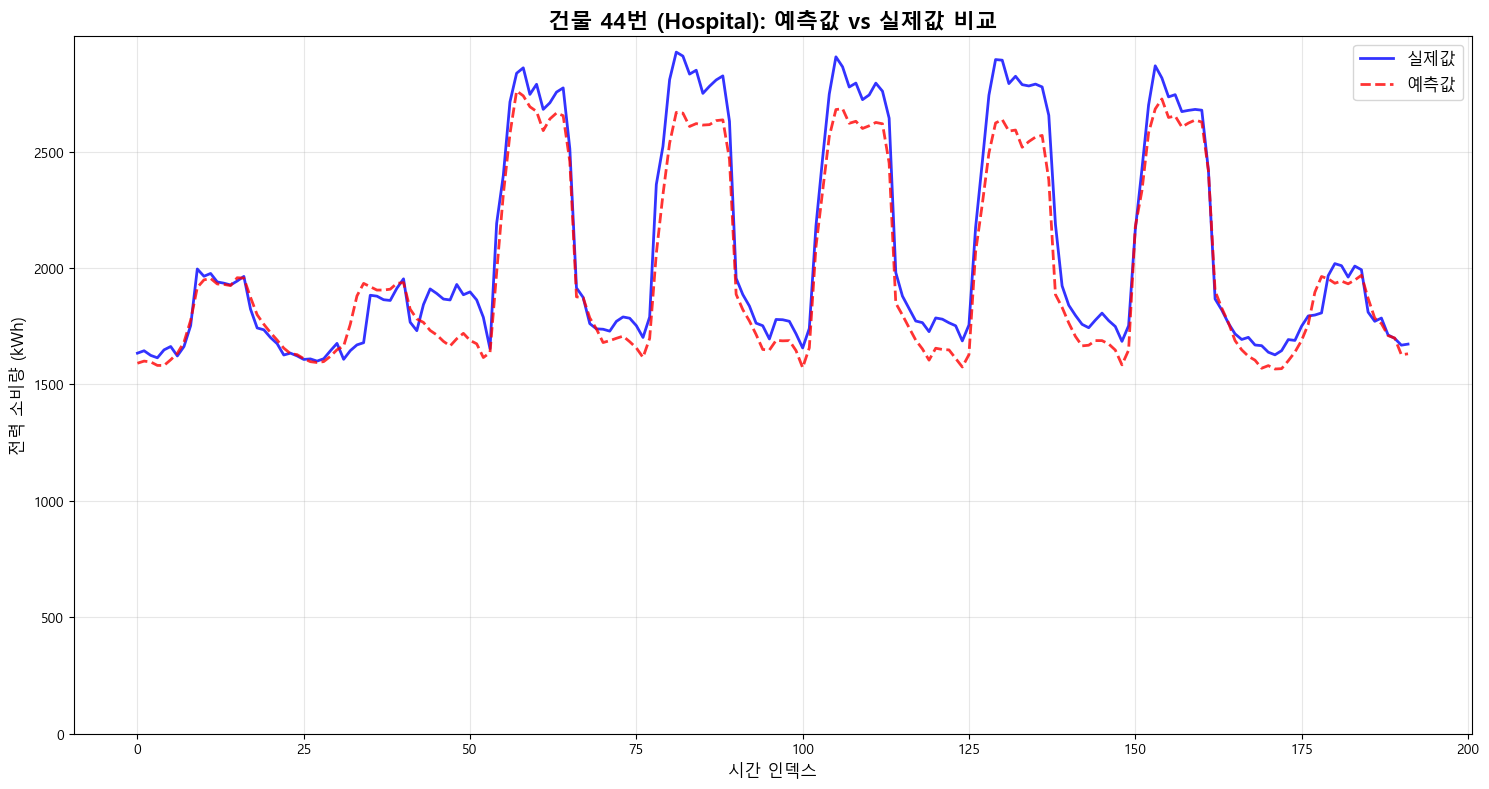

‚úÖ Í±¥Î¨º 44Î≤à (Hospital) ÏãúÍ∞ÅÌôî ÏôÑÎ£å
   ÔøΩÔøΩ Îç∞Ïù¥ÌÑ∞ Ïàò: 192Í∞ú
   ÔøΩÔøΩ SMAPE: 4.61
   ÔøΩÔøΩ MAE: 96.89 kWh
   üìà MAPE: 4.49%


In [91]:
building_visualization2(n)
n+=1

üîç Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ ÏÑ±Îä• Î∂ÑÏÑù Î∞è Î¨∏Ï†ú Í±¥Î¨º ÏãùÎ≥Ñ...
ÔøΩÔøΩ Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ ÏÑ±Îä• ÌÜµÍ≥Ñ:
   Ï¥ù Í±¥Î¨º Ïàò: 100Í∞ú
   Ï†ÑÏ≤¥ ÌèâÍ∑† SMAPE: 6.3148
   ÏµúÍ≥† ÏÑ±Îä• SMAPE: 0.3653
   ÏµúÏ†Ä ÏÑ±Îä• SMAPE: 24.1164
   SMAPE ÌëúÏ§ÄÌé∏Ï∞®: 4.6664

‚ö†Ô∏è ÌèâÍ∑†Î≥¥Îã§ ÎÜíÏùÄ SMAPEÎ•º Í∞ÄÏßÑ Í±¥Î¨ºÎì§:
   Í±¥Î¨º Ïàò: 35Í∞ú
   ÎπÑÏú®: 35.0%

üìà ÏÑ±Îä•Î≥Ñ Í±¥Î¨º Î∂ÑÎ•ò:
   Îß§Ïö∞ Ï¢ãÏùå (ÌèâÍ∑†Ïùò 50% Ïù¥Ìïò): 23Í∞ú
   Ï¢ãÏùå (ÌèâÍ∑†Ïùò 50-100%): 42Í∞ú
   Î≥¥ÌÜµ (ÌèâÍ∑†Ïùò 100-150%): 14Í∞ú
   ÎÇòÏÅ® (ÌèâÍ∑†Ïùò 150-200%): 12Í∞ú
   Îß§Ïö∞ ÎÇòÏÅ® (ÌèâÍ∑†Ïùò 200% Ïù¥ÏÉÅ): 9Í∞ú

ÔøΩÔøΩ Î¨∏Ï†ú Í±¥Î¨º ÏÉÅÏÑ∏ Î∂ÑÏÑù (SMAPE > 6.3148):
 1. Í±¥Î¨º 94 (Research Institute): SMAPE  24.12 (ÌèâÍ∑†Ïùò  3.8Î∞∞)
 2. Í±¥Î¨º 10 (Hotel          ): SMAPE  21.68 (ÌèâÍ∑†Ïùò  3.4Î∞∞)
 3. Í±¥Î¨º 23 (Research Institute): SMAPE  21.55 (ÌèâÍ∑†Ïùò  3.4Î∞∞)
 4. Í±¥Î¨º 87 (University     ): SMAPE  18.34 (ÌèâÍ∑†Ïùò  2.9Î∞∞)
 5. Í±¥Î¨º 100 (Hotel          ): SMAPE  17.07 (ÌèâÍ∑†Ïùò  2.7Î∞∞)
 6. Í±¥Î¨º 49 (Re

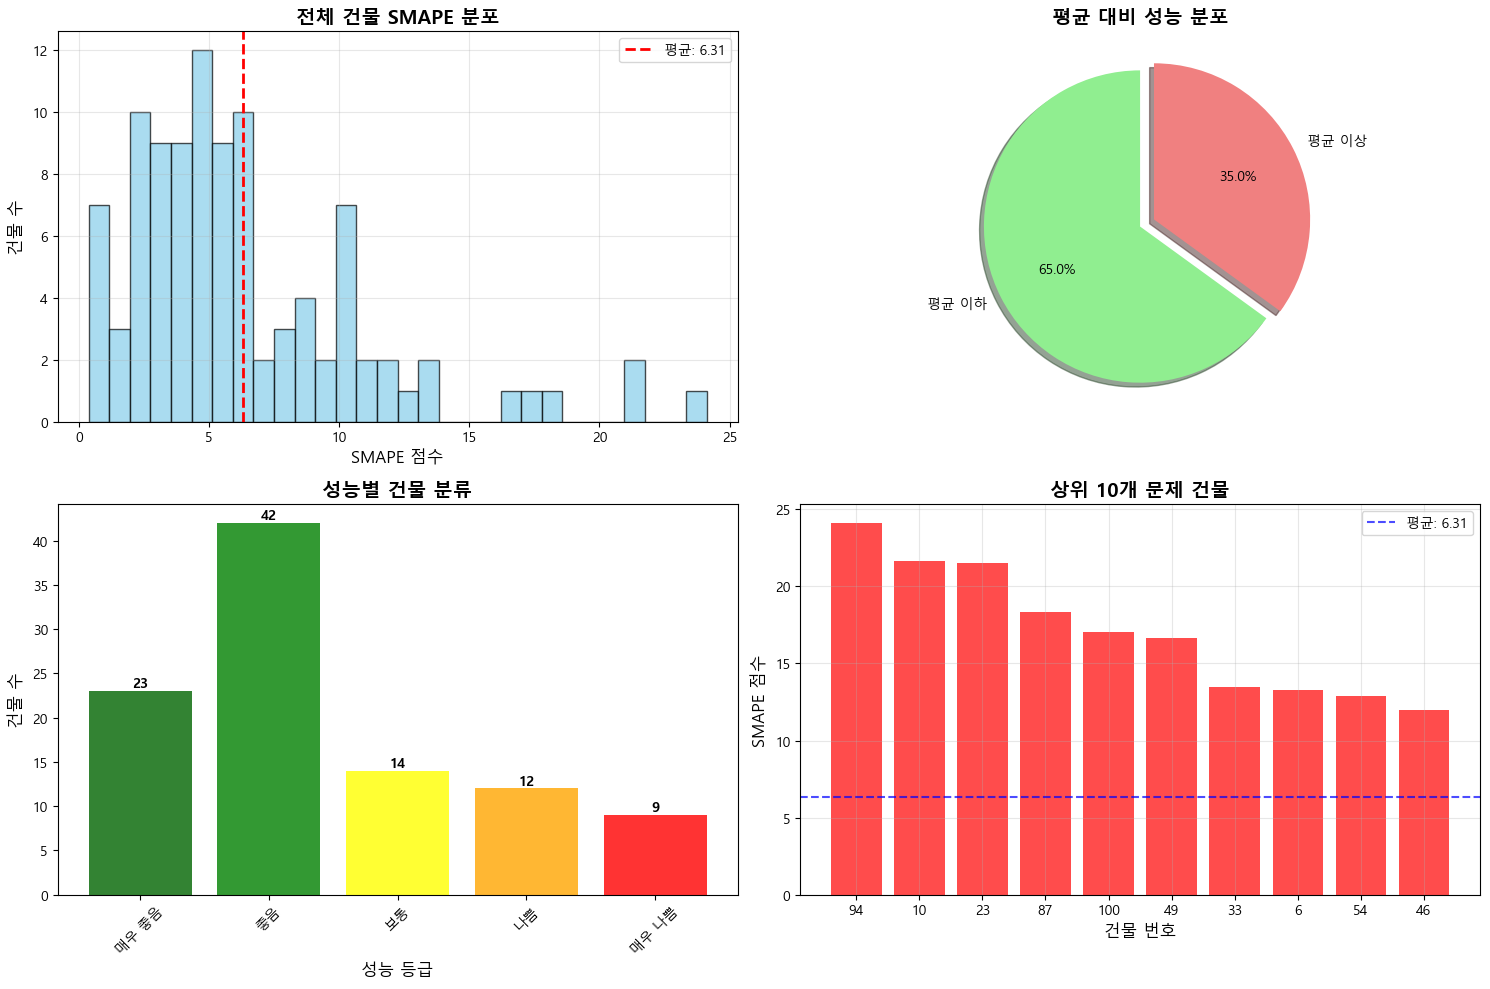


üí° Î¨∏Ï†ú Í±¥Î¨º Í∞úÏÑ† Î∞©Ïïà:
ÔøΩÔøΩ SMAPEÍ∞Ä ÌèâÍ∑†Î≥¥Îã§ ÎÜíÏùÄ Í±¥Î¨ºÎì§Ïóê ÎåÄÌïú Í∞úÏÑ† Î∞©Ïïà:

   ÔøΩÔøΩ Hotel Í±¥Î¨ºÎì§ (4Í∞ú):
      Í±¥Î¨º Î≤àÌò∏: [1, 10, 77, 100]
      üí° Í∞úÏÑ† Î∞©Ïïà: Í±¥Î¨ºÎ≥Ñ ÌäπÏàò Ìå®ÌÑ¥ Î∂ÑÏÑù, Ï∂îÍ∞Ä ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ

   ÔøΩÔøΩ Commercial Í±¥Î¨ºÎì§ (2Í∞ú):
      Í±¥Î¨º Î≤àÌò∏: [6, 86]
      üí° Í∞úÏÑ† Î∞©Ïïà: Í±¥Î¨ºÎ≥Ñ ÌäπÏàò Ìå®ÌÑ¥ Î∂ÑÏÑù, Ï∂îÍ∞Ä ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ

   ÔøΩÔøΩ Other Buildings Í±¥Î¨ºÎì§ (4Í∞ú):
      Í±¥Î¨º Î≤àÌò∏: [7, 26, 47, 61]
      üí° Í∞úÏÑ† Î∞©Ïïà: Í±¥Î¨ºÎ≥Ñ ÌäπÏàò Ìå®ÌÑ¥ Î∂ÑÏÑù, Ï∂îÍ∞Ä ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ

   ÔøΩÔøΩ University Í±¥Î¨ºÎì§ (3Í∞ú):
      Í±¥Î¨º Î≤àÌò∏: [8, 46, 87]
      ÔøΩÔøΩ Í∞úÏÑ† Î∞©Ïïà: ÌïôÍ∏∞/Î∞©Ìïô Ìå®ÌÑ¥ Î∞òÏòÅ, ÏàòÏóÖ ÏãúÍ∞ÑÎåÄ ÌäπÏÑ± Í≥†Î†§

   ÔøΩÔøΩ Research Institute Í±¥Î¨ºÎì§ (7Í∞ú):
      Í±¥Î¨º Î≤àÌò∏: [13, 15, 23, 37, 49, 53, 94]
      üí° Í∞úÏÑ† Î∞©Ïïà: Í±¥Î¨ºÎ≥Ñ ÌäπÏàò Ìå®ÌÑ¥ Î∂ÑÏÑù, Ï∂îÍ∞Ä ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ

   ÔøΩÔøΩ Department Store Í±¥Î¨ºÎì§ (7Í∞ú):
      Í±¥Î¨º 

In [33]:
## 8. Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ ÏÑ±Îä• Î∂ÑÏÑù Î∞è Î¨∏Ï†ú Í±¥Î¨º ÏãùÎ≥Ñ
print("üîç Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ ÏÑ±Îä• Î∂ÑÏÑù Î∞è Î¨∏Ï†ú Í±¥Î¨º ÏãùÎ≥Ñ...")
print("=" * 60)

# 1. Í∏∞Î≥∏ ÌÜµÍ≥Ñ Î∂ÑÏÑù
print("ÔøΩÔøΩ Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ ÏÑ±Îä• ÌÜµÍ≥Ñ:")
print(f"   Ï¥ù Í±¥Î¨º Ïàò: {len(individual_model_scores)}Í∞ú")
print(f"   Ï†ÑÏ≤¥ ÌèâÍ∑† SMAPE: {total_individual_smape:.4f}")
print(f"   ÏµúÍ≥† ÏÑ±Îä• SMAPE: {min(individual_model_scores.values()):.4f}")
print(f"   ÏµúÏ†Ä ÏÑ±Îä• SMAPE: {max(individual_model_scores.values()):.4f}")
print(f"   SMAPE ÌëúÏ§ÄÌé∏Ï∞®: {np.std(list(individual_model_scores.values())):.4f}")

# 2. ÌèâÍ∑†Î≥¥Îã§ ÎÜíÏùÄ SMAPEÎ•º Í∞ÄÏßÑ Í±¥Î¨ºÎì§ Ï∞æÍ∏∞
mean_smape = total_individual_smape
above_average_buildings = {}

for building_num, smape_score in individual_model_scores.items():
    if smape_score > mean_smape:
        above_average_buildings[building_num] = smape_score

print(f"\n‚ö†Ô∏è ÌèâÍ∑†Î≥¥Îã§ ÎÜíÏùÄ SMAPEÎ•º Í∞ÄÏßÑ Í±¥Î¨ºÎì§:")
print(f"   Í±¥Î¨º Ïàò: {len(above_average_buildings)}Í∞ú")
print(f"   ÎπÑÏú®: {len(above_average_buildings)/len(individual_model_scores)*100:.1f}%")

# 3. ÏÑ±Îä•Î≥Ñ Í±¥Î¨º Î∂ÑÎ•ò
performance_categories = {
    'excellent': [],      # ÌèâÍ∑†Ïùò 50% Ïù¥Ìïò (Îß§Ïö∞ Ï¢ãÏùå)
    'good': [],           # ÌèâÍ∑†Ïùò 50-100% (Ï¢ãÏùå)
    'average': [],        # ÌèâÍ∑†Ïùò 100-150% (Î≥¥ÌÜµ)
    'poor': [],           # ÌèâÍ∑†Ïùò 150-200% (ÎÇòÏÅ®)
    'very_poor': []       # ÌèâÍ∑†Ïùò 200% Ïù¥ÏÉÅ (Îß§Ïö∞ ÎÇòÏÅ®)
}

for building_num, smape_score in individual_model_scores.items():
    ratio = smape_score / mean_smape
    
    if ratio <= 0.5:
        performance_categories['excellent'].append((building_num, smape_score))
    elif ratio <= 1.0:
        performance_categories['good'].append((building_num, smape_score))
    elif ratio <= 1.5:
        performance_categories['average'].append((building_num, smape_score))
    elif ratio <= 2.0:
        performance_categories['poor'].append((building_num, smape_score))
    else:
        performance_categories['very_poor'].append((building_num, smape_score))

# 4. ÏÑ±Îä•Î≥Ñ Î∂ÑÎ•ò Í≤∞Í≥º Ï∂úÎ†•
print(f"\nüìà ÏÑ±Îä•Î≥Ñ Í±¥Î¨º Î∂ÑÎ•ò:")
for category, buildings in performance_categories.items():
    if buildings:
        category_names = {
            'excellent': 'Îß§Ïö∞ Ï¢ãÏùå (ÌèâÍ∑†Ïùò 50% Ïù¥Ìïò)',
            'good': 'Ï¢ãÏùå (ÌèâÍ∑†Ïùò 50-100%)',
            'average': 'Î≥¥ÌÜµ (ÌèâÍ∑†Ïùò 100-150%)',
            'poor': 'ÎÇòÏÅ® (ÌèâÍ∑†Ïùò 150-200%)',
            'very_poor': 'Îß§Ïö∞ ÎÇòÏÅ® (ÌèâÍ∑†Ïùò 200% Ïù¥ÏÉÅ)'
        }
        print(f"   {category_names[category]}: {len(buildings)}Í∞ú")

# 5. Î¨∏Ï†ú Í±¥Î¨º ÏÉÅÏÑ∏ Î∂ÑÏÑù (ÌèâÍ∑†Î≥¥Îã§ ÎÜíÏùÄ SMAPE)
if above_average_buildings:
    print(f"\nÔøΩÔøΩ Î¨∏Ï†ú Í±¥Î¨º ÏÉÅÏÑ∏ Î∂ÑÏÑù (SMAPE > {mean_smape:.4f}):")
    print("=" * 80)
    
    # SMAPE Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨ (ÎÜíÏùÄ Ïàú)
    sorted_problem_buildings = sorted(above_average_buildings.items(), 
                                     key=lambda x: x[1], reverse=True)
    
    # Í±¥Î¨º Ï†ïÎ≥¥ÏôÄ Ìï®Íªò Ï∂úÎ†•
    for i, (building_num, smape_score) in enumerate(sorted_problem_buildings[:20], 1):  # ÏÉÅÏúÑ 20Í∞ú
        building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
        ratio_to_mean = smape_score / mean_smape
        
        print(f"{i:2d}. Í±¥Î¨º {building_num:2d} ({building_type:15s}): "
              f"SMAPE {smape_score:6.2f} (ÌèâÍ∑†Ïùò {ratio_to_mean:4.1f}Î∞∞)")
    
    if len(sorted_problem_buildings) > 20:
        print(f"   ... Î∞è {len(sorted_problem_buildings) - 20}Í∞ú Îçî")

# 6. Í±¥Î¨º Ïú†ÌòïÎ≥Ñ ÏÑ±Îä• Î∂ÑÏÑù
print(f"\nüè¢ Í±¥Î¨º Ïú†ÌòïÎ≥Ñ ÏÑ±Îä• Î∂ÑÏÑù:")
building_type_performance = {}

for building_num, smape_score in individual_model_scores.items():
    building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
    
    if building_type not in building_type_performance:
        building_type_performance[building_type] = []
    
    building_type_performance[building_type].append(smape_score)

for building_type, scores in building_type_performance.items():
    avg_type_smape = np.mean(scores)
    count = len(scores)
    ratio_to_overall = avg_type_smape / mean_smape
    
    performance_indicator = "üî¥" if ratio_to_overall > 1.2 else "üü°" if ratio_to_overall > 1.0 else "ÔøΩÔøΩ"
    
    print(f"   {performance_indicator} {building_type:20s}: "
          f"ÌèâÍ∑† SMAPE {avg_type_smape:6.2f} (Í±¥Î¨º {count:2d}Í∞ú, "
          f"Ï†ÑÏ≤¥ ÌèâÍ∑†Ïùò {ratio_to_overall:4.1f}Î∞∞)")

# 7. Î¨∏Ï†ú Í±¥Î¨º ÏãúÍ∞ÅÌôî
print(f"\nüìä Î¨∏Ï†ú Í±¥Î¨º ÏãúÍ∞ÅÌôî...")

# SMAPE Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
plt.figure(figsize=(15, 10))

# 1. Ï†ÑÏ≤¥ SMAPE Î∂ÑÌè¨
plt.subplot(2, 2, 1)
smape_values = list(individual_model_scores.values())
plt.hist(smape_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(mean_smape, color='red', linestyle='--', linewidth=2, label=f'ÌèâÍ∑†: {mean_smape:.2f}')
plt.title('Ï†ÑÏ≤¥ Í±¥Î¨º SMAPE Î∂ÑÌè¨', fontsize=14, fontweight='bold')
plt.xlabel('SMAPE Ï†êÏàò', fontsize=12)
plt.ylabel('Í±¥Î¨º Ïàò', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# 2. ÌèâÍ∑† Ïù¥ÏÉÅ vs Ïù¥Ìïò Í±¥Î¨º Ïàò
plt.subplot(2, 2, 2)
below_average_count = len(individual_model_scores) - len(above_average_buildings)
above_average_count = len(above_average_buildings)

labels = ['ÌèâÍ∑† Ïù¥Ìïò', 'ÌèâÍ∑† Ïù¥ÏÉÅ']
sizes = [below_average_count, above_average_count]
colors = ['lightgreen', 'lightcoral']
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, shadow=True)
plt.title('ÌèâÍ∑† ÎåÄÎπÑ ÏÑ±Îä• Î∂ÑÌè¨', fontsize=14, fontweight='bold')

# 3. ÏÑ±Îä•Î≥Ñ Í±¥Î¨º Ïàò
plt.subplot(2, 2, 3)
category_labels = ['Îß§Ïö∞ Ï¢ãÏùå', 'Ï¢ãÏùå', 'Î≥¥ÌÜµ', 'ÎÇòÏÅ®', 'Îß§Ïö∞ ÎÇòÏÅ®']
category_counts = [len(performance_categories[cat]) for cat in ['excellent', 'good', 'average', 'poor', 'very_poor']]
category_colors = ['darkgreen', 'green', 'yellow', 'orange', 'red']

bars = plt.bar(category_labels, category_counts, color=category_colors, alpha=0.8)
plt.title('ÏÑ±Îä•Î≥Ñ Í±¥Î¨º Î∂ÑÎ•ò', fontsize=14, fontweight='bold')
plt.xlabel('ÏÑ±Îä• Îì±Í∏â', fontsize=12)
plt.ylabel('Í±¥Î¨º Ïàò', fontsize=12)
plt.xticks(rotation=45)

# ÎßâÎåÄ ÏúÑÏóê Í∞í ÌëúÏãú
for bar, count in zip(bars, category_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{count}', ha='center', va='bottom', fontweight='bold')

# 4. ÏÉÅÏúÑ Î¨∏Ï†ú Í±¥Î¨º 10Í∞ú
plt.subplot(2, 2, 4)
if above_average_buildings:
    top_10_problem = sorted(above_average_buildings.items(), key=lambda x: x[1], reverse=True)[:10]
    building_nums, smape_scores = zip(*top_10_problem)
    
    bars = plt.bar(range(len(building_nums)), smape_scores, color='red', alpha=0.7)
    plt.title('ÏÉÅÏúÑ 10Í∞ú Î¨∏Ï†ú Í±¥Î¨º', fontsize=14, fontweight='bold')
    plt.xlabel('Í±¥Î¨º Î≤àÌò∏', fontsize=12)
    plt.ylabel('SMAPE Ï†êÏàò', fontsize=12)
    plt.xticks(range(len(building_nums)), building_nums)
    plt.axhline(mean_smape, color='blue', linestyle='--', alpha=0.7, label=f'ÌèâÍ∑†: {mean_smape:.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('individual_building_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. Î¨∏Ï†ú Í±¥Î¨º Í∞úÏÑ† Î∞©Ïïà Ï†úÏãú
print(f"\nüí° Î¨∏Ï†ú Í±¥Î¨º Í∞úÏÑ† Î∞©Ïïà:")
print("=" * 60)

if above_average_buildings:
    print("ÔøΩÔøΩ SMAPEÍ∞Ä ÌèâÍ∑†Î≥¥Îã§ ÎÜíÏùÄ Í±¥Î¨ºÎì§Ïóê ÎåÄÌïú Í∞úÏÑ† Î∞©Ïïà:")
    
    # Í±¥Î¨º Ïú†ÌòïÎ≥ÑÎ°ú Í∑∏Î£πÌôî
    problem_by_type = {}
    for building_num in above_average_buildings.keys():
        building_type = building_info[building_info['building_number'] == building_num]['building_type'].iloc[0]
        if building_type not in problem_by_type:
            problem_by_type[building_type] = []
        problem_by_type[building_type].append(building_num)
    
    for building_type, buildings in problem_by_type.items():
        print(f"\n   ÔøΩÔøΩ {building_type} Í±¥Î¨ºÎì§ ({len(buildings)}Í∞ú):")
        print(f"      Í±¥Î¨º Î≤àÌò∏: {buildings}")
        
        # Í±¥Î¨º Ïú†ÌòïÎ≥Ñ Í∞úÏÑ† Î∞©Ïïà
        if building_type == 'Department Store':
            print(f"      üí° Í∞úÏÑ† Î∞©Ïïà: Î∞±ÌôîÏ†ê ÌäπÏÑ± Î∞òÏòÅ, Ìú¥Ïùº Ìå®ÌÑ¥ Í∞ïÌôî, Í≥ÑÏ†àÏÑ± ÌîºÏ≤ò Ï∂îÍ∞Ä")
        elif building_type == 'IDC':
            print(f"      üí° Í∞úÏÑ† Î∞©Ïïà: 24ÏãúÍ∞Ñ Ïö¥ÏòÅ ÌäπÏÑ± Î∞òÏòÅ, Î∂ÄÌïò Ìå®ÌÑ¥ Î∂ÑÏÑù, Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨ Í∞ïÌôî")
        elif building_type == 'Hospital':
            print(f"      ÔøΩÔøΩ Í∞úÏÑ† Î∞©Ïïà: ÏùëÍ∏â ÏÉÅÌô© Ìå®ÌÑ¥ Î∞òÏòÅ, ÏïºÍ∞Ñ Ïö¥ÏòÅ ÌäπÏÑ± Í≥†Î†§")
        elif building_type == 'University':
            print(f"      ÔøΩÔøΩ Í∞úÏÑ† Î∞©Ïïà: ÌïôÍ∏∞/Î∞©Ìïô Ìå®ÌÑ¥ Î∞òÏòÅ, ÏàòÏóÖ ÏãúÍ∞ÑÎåÄ ÌäπÏÑ± Í≥†Î†§")
        else:
            print(f"      üí° Í∞úÏÑ† Î∞©Ïïà: Í±¥Î¨ºÎ≥Ñ ÌäπÏàò Ìå®ÌÑ¥ Î∂ÑÏÑù, Ï∂îÍ∞Ä ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ")

print(f"\n‚úÖ Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ ÏÑ±Îä• Î∂ÑÏÑù ÏôÑÎ£å")
print(f"üìÅ Í≤∞Í≥º Ï†ÄÏû•: individual_building_performance_analysis.png")

In [93]:
print("üéØ ÏïôÏÉÅÎ∏î Î™®Îç∏ ÏÉùÏÑ± Ï§ë...")
print("=" * 50)

# ÏïôÏÉÅÎ∏î Í∞ÄÏ§ëÏπò ÏÑ§Ï†ï (Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏Ïóê Îçî ÎÜíÏùÄ Í∞ÄÏ§ëÏπò)
individual_weight = 0.7  # Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ Í∞ÄÏ§ëÏπò
type_weight = 0.3        # Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ Í∞ÄÏ§ëÏπò

print(f"üìä ÏïôÏÉÅÎ∏î Í∞ÄÏ§ëÏπò:")
print(f"   Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏: {individual_weight * 100}%")
print(f"   Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏: {type_weight * 100}%")

# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏïôÏÉÅÎ∏î
ensemble_oof = (
    individual_model_oof["pred"] * individual_weight + 
    type_model_oof["pred"] * type_weight
)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏïôÏÉÅÎ∏î
ensemble_predictions = (
    individual_model_predictions["answer"] * individual_weight + 
    type_model_predictions["answer"] * type_weight
)

# ÏïôÏÉÅÎ∏î ÏÑ±Îä• Í≥ÑÏÇ∞
ensemble_smape = smape(
    Y.sort_index()["power_consumption"].values,
    ensemble_oof.sort_index().values
)

print(f"\nüèÜ ÏÑ±Îä• ÎπÑÍµê:")
print(f"   Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ SMAPE: {total_type_smape:.4f}")
print(f"   Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ SMAPE: {total_individual_smape:.4f}")
print(f"   ÏïôÏÉÅÎ∏î Î™®Îç∏ SMAPE: {ensemble_smape:.4f}")

# ÏÑ±Îä• Ìñ•ÏÉÅ ÌôïÏù∏
improvement_vs_type = total_type_smape - ensemble_smape
improvement_vs_individual = total_individual_smape - ensemble_smape

print(f"\nüìà ÏÑ±Îä• Ìñ•ÏÉÅ:")
print(f"   vs Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ: {improvement_vs_type:+.4f} SMAPE")
print(f"   vs Í∞úÎ≥Ñ Í±¥Î¨º: {improvement_vs_individual:+.4f} SMAPE")

if ensemble_smape < min(total_type_smape, total_individual_smape):
    print("\nüéâ ÏïôÏÉÅÎ∏îÏù¥ Í∞úÎ≥Ñ Î™®Îç∏Îì§Î≥¥Îã§ Ïö∞ÏàòÌïú ÏÑ±Îä•ÏùÑ Î≥¥ÏûÖÎãàÎã§!")
else:
    print("\n‚ö†Ô∏è ÏïôÏÉÅÎ∏î ÏÑ±Îä•Ïù¥ Í∏∞ÎåÄÎ≥¥Îã§ ÎÇÆÏäµÎãàÎã§. Í∞ÄÏ§ëÏπò Ï°∞Ï†ïÏùÑ Í≥†Î†§Ìï¥Î≥¥ÏÑ∏Ïöî.")

print("‚úÖ ÏïôÏÉÅÎ∏î Î™®Îç∏ ÏÉùÏÑ± ÏôÑÎ£å")


üéØ ÏïôÏÉÅÎ∏î Î™®Îç∏ ÏÉùÏÑ± Ï§ë...
üìä ÏïôÏÉÅÎ∏î Í∞ÄÏ§ëÏπò:
   Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏: 70.0%
   Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏: 30.0%

üèÜ ÏÑ±Îä• ÎπÑÍµê:
   Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏ SMAPE: nan
   Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏ SMAPE: 6.2138
   ÏïôÏÉÅÎ∏î Î™®Îç∏ SMAPE: nan

üìà ÏÑ±Îä• Ìñ•ÏÉÅ:
   vs Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ: +nan SMAPE
   vs Í∞úÎ≥Ñ Í±¥Î¨º: +nan SMAPE

‚ö†Ô∏è ÏïôÏÉÅÎ∏î ÏÑ±Îä•Ïù¥ Í∏∞ÎåÄÎ≥¥Îã§ ÎÇÆÏäµÎãàÎã§. Í∞ÄÏ§ëÏπò Ï°∞Ï†ïÏùÑ Í≥†Î†§Ìï¥Î≥¥ÏÑ∏Ïöî.
‚úÖ ÏïôÏÉÅÎ∏î Î™®Îç∏ ÏÉùÏÑ± ÏôÑÎ£å


In [94]:
print("üìù Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ± Ï§ë...")

# Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
submission = sample_submission.copy()
submission["answer"] = ensemble_predictions.values

# ÏùåÏàòÍ∞í Ï≤òÎ¶¨ (Ï†ÑÎ†• ÏÜåÎπÑÎüâÏùÄ ÏùåÏàòÍ∞Ä Îê† Ïàò ÏóÜÏùå)
submission["answer"] = np.maximum(submission["answer"], 0)

# Í≤∞Í≥º Ï†ÄÏû•
submission.to_csv('ensemble_submission.csv', index=False)

print("‚úÖ Ï†úÏ∂ú ÌååÏùº Ï†ÄÏû•: ensemble_submission.csv")

# ÏòàÏ∏° Í≤∞Í≥º ÌÜµÍ≥Ñ
print(f"\nüìä ÏòàÏ∏° Í≤∞Í≥º ÌÜµÍ≥Ñ:")
print(f"   ÏòàÏ∏° ÌèâÍ∑†: {submission['answer'].mean():.2f} kWh")
print(f"   ÏòàÏ∏° Ï§ëÏïôÍ∞í: {submission['answer'].median():.2f} kWh")
print(f"   ÏòàÏ∏° Î≤îÏúÑ: {submission['answer'].min():.2f} ~ {submission['answer'].max():.2f} kWh")
print(f"   ÏòàÏ∏° ÌëúÏ§ÄÌé∏Ï∞®: {submission['answer'].std():.2f} kWh")

# Ï†úÏ∂ú ÌååÏùº ÎØ∏Î¶¨Î≥¥Í∏∞
print(f"\nüìã Ï†úÏ∂ú ÌååÏùº ÎØ∏Î¶¨Î≥¥Í∏∞:")
display(submission.head(10))

# Í∞úÎ≥Ñ Î™®Îç∏ Í≤∞Í≥ºÎèÑ Ï†ÄÏû•
individual_submission = sample_submission.copy()
individual_submission["answer"] = np.maximum(individual_model_predictions["answer"].values, 0)
individual_submission.to_csv('individual_model_submission.csv', index=False)

type_submission = sample_submission.copy()
type_submission["answer"] = np.maximum(type_model_predictions["answer"].values, 0)
type_submission.to_csv('type_model_submission.csv', index=False)

# Ï∂îÍ∞Ä: Îã§ÏñëÌïú ÏïôÏÉÅÎ∏î ÎπÑÏú®Ïùò Ï†úÏ∂ú ÌååÏùºÎì§ÎèÑ ÏÉùÏÑ± (ÏÉÅÏúÑ 3Í∞ú)
print(f"\nüìÅ ÏÉÅÏúÑ 3Í∞ú ÏïôÏÉÅÎ∏î Ï°∞Ìï© Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±...")
for i, result in enumerate(top_5_results[:3], 1):
    weight_individual = result['individual_weight']
    weight_type = result['type_weight']
    
    # Ìï¥Îãπ ÎπÑÏú®Î°ú ÏïôÏÉÅÎ∏î ÏòàÏ∏°
    ensemble_pred = (
        individual_model_predictions["answer"] * weight_individual + 
        type_model_predictions["answer"] * weight_type
    )
    
    # Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
    temp_submission = sample_submission.copy()
    temp_submission["answer"] = np.maximum(ensemble_pred.values, 0)
    filename = f'ensemble_rank{i}_{weight_individual*100:.0f}_{weight_type*100:.0f}_submission.csv'
    temp_submission.to_csv(filename, index=False)
    
    print(f"   {i}ÏàúÏúÑ: {filename} (Í∞úÎ≥Ñ {weight_individual*100:.0f}% + ÌÉÄÏûÖÎ≥Ñ {weight_type*100:.0f}%)")

print("\n‚úÖ Î™®Îì† Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ± ÏôÑÎ£å:")
print("   - optimal_ensemble_submission.csv (ÏµúÏ†Å ÎπÑÏú®)")
print("   - individual_model_submission.csv (Í∞úÎ≥Ñ Í±¥Î¨º Î™®Îç∏)")
print("   - type_model_submission.csv (ÌÉÄÏûÖÎ≥Ñ Î™®Îç∏)")
print("   - ensemble_rank1_XX_XX_submission.csv (1ÏàúÏúÑ ÏïôÏÉÅÎ∏î)")
print("   - ensemble_rank2_XX_XX_submission.csv (2ÏàúÏúÑ ÏïôÏÉÅÎ∏î)")
print("   - ensemble_rank3_XX_XX_submission.csv (3ÏàúÏúÑ ÏïôÏÉÅÎ∏î)")


üìù Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ± Ï§ë...
‚úÖ Ï†úÏ∂ú ÌååÏùº Ï†ÄÏû•: ensemble_submission.csv

üìä ÏòàÏ∏° Í≤∞Í≥º ÌÜµÍ≥Ñ:
   ÏòàÏ∏° ÌèâÍ∑†: 3483.06 kWh
   ÏòàÏ∏° Ï§ëÏïôÍ∞í: 2035.29 kWh
   ÏòàÏ∏° Î≤îÏúÑ: 11.39 ~ 24953.94 kWh
   ÏòàÏ∏° ÌëúÏ§ÄÌé∏Ï∞®: 3771.01 kWh

üìã Ï†úÏ∂ú ÌååÏùº ÎØ∏Î¶¨Î≥¥Í∏∞:


num_date_time       answer
0  1_20240825 00  4547.313916
1  1_20240825 01  4368.625928
2  1_20240825 02  4174.126416
3  1_20240825 03  4004.462329
4  1_20240825 04  4050.845361
5  1_20240825 05  3710.446289
6  1_20240825 06  3832.179395
7  1_20240825 07  4351.884277
8  1_20240825 08  4883.058154
9  1_20240825 09  6158.179346


üìÅ ÏÉÅÏúÑ 3Í∞ú ÏïôÏÉÅÎ∏î Ï°∞Ìï© Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±...


NameError: name 'top_5_results' is not defined